# Snake

In [1]:
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
print(physical_devices)
for gpu in physical_devices:
    tf.config.experimental.set_memory_growth(gpu, True)

tf.random.set_seed(0)

import environments_fully_observable 
import environments_partially_observable
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt
import os
import random
# import tensorflow as tf
# tf.random.set_seed(0)
random.seed(0)
np.random.seed(0)

# GPU configuration
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("TensorFlow version:", tf.__version__)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Num GPUs Available:  1
TensorFlow version: 2.10.1


## Environment definition

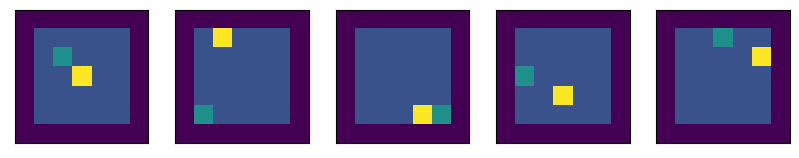

In [2]:
%matplotlib inline
# function to standardize getting an env for the whole notebook
def get_env(n=1000, partially_observable=False):
    # n is the number of boards that you want to simulate parallely
    # size is the size of each board, also considering the borders
    # mask for the partially observable, is the size of the local neighborhood
    size = 7
    if partially_observable:
        e = environments_partially_observable.OriginalSnakeEnvironment(n, size, 3)
    else:
        e = environments_fully_observable.OriginalSnakeEnvironment(n, size)
    # or environments_partially_observable.OriginalSnakeEnvironment(n, size, 2)
    return e
env_ = get_env()
GAMMA = .9
ITERATIONS = 5000

fig,axs=plt.subplots(1,min(len(env_.boards), 5), figsize=(10,3))
for ax, board in zip(axs, env_.boards):
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    ax.imshow(board, origin="lower")

## DQN Agent

In [3]:
from dqn import DQNAgent

agent = DQNAgent(state_shape=env_.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

## Training

In [4]:
def training(iterations, env, agent, save_weights=True, save_path="weights/", file_name="weights.h5"):
    rewards_hist = []
    walls_hist = []
    fruit_hist = []
    loss_hist = []
    max_fruits_eaten = 0

    for iteration in trange(iterations):
        state = tf.constant(env.to_state())
        actions = agent.select_action(state)
        rewards = env.move(actions)
        new_state = tf.constant(env.to_state())
        dones = np.isin(rewards, [env_.WIN_REWARD, env_.HIT_WALL_REWARD, env_.ATE_HIMSELF_REWARD])
        loss = agent.train(state, actions, rewards, new_state, dones)
        mean_reward = tf.reduce_mean(rewards).numpy()
        rewards_hist.append(mean_reward)
        if loss is not None:
            loss_hist.append(loss)
        wall_hits_count = np.sum(rewards == env_.HIT_WALL_REWARD)
        walls_hist.append(wall_hits_count)

        fruits_eaten_count = np.sum(rewards == env_.FRUIT_REWARD)
        fruit_hist.append(fruits_eaten_count)

        if iteration % 100 == 0:
            avg_reward = np.mean(rewards_hist[-100:]) if rewards_hist else 0
            avg_loss = np.mean(loss_hist[-100:]) if loss_hist else 0

            fruits_eaten = tf.reduce_sum(tf.cast(rewards == 0.5, tf.int32)).numpy()
            max_fruits_eaten = max(max_fruits_eaten, fruits_eaten)
            print(f"Iteration {iteration}: Avg Reward: {avg_reward:.2f}, Avg Loss: {avg_loss:.4f}")
            print(f"Fruits eaten: {fruits_eaten}, Max fruits eaten: {max_fruits_eaten}")
            print(f"Wall hits: {wall_hits_count}")

    if save_weights:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        agent.save_weights(os.path.join(save_path, file_name))
        print(f"Weights saved to {os.path.join(save_path, file_name)}")

    return rewards_hist, walls_hist, fruit_hist, loss_hist

In [5]:
rewards_history, wall_hits, fruits_eaten_, loss_history = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_dqn_weights.h5")

  0%|          | 1/5000 [00:02<4:05:02,  2.94s/it]

Iteration 0: Avg Reward: 0.00, Avg Loss: 0.0428
Fruits eaten: 40, Max fruits eaten: 40
Wall hits: 192


  2%|▏         | 101/5000 [01:48<1:35:24,  1.17s/it]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0088
Fruits eaten: 21, Max fruits eaten: 40
Wall hits: 167


  4%|▍         | 201/5000 [03:34<1:16:04,  1.05it/s]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0057
Fruits eaten: 28, Max fruits eaten: 40
Wall hits: 182


  6%|▌         | 301/5000 [05:10<1:14:46,  1.05it/s]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0058
Fruits eaten: 32, Max fruits eaten: 40
Wall hits: 0


  8%|▊         | 401/5000 [06:46<1:13:35,  1.04it/s]

Iteration 400: Avg Reward: -0.01, Avg Loss: 0.0069
Fruits eaten: 49, Max fruits eaten: 49
Wall hits: 0


 10%|█         | 501/5000 [08:24<1:14:04,  1.01it/s]

Iteration 500: Avg Reward: -0.00, Avg Loss: 0.0077
Fruits eaten: 21, Max fruits eaten: 49
Wall hits: 191


 12%|█▏        | 601/5000 [10:00<1:09:04,  1.06it/s]

Iteration 600: Avg Reward: -0.00, Avg Loss: 0.0089
Fruits eaten: 19, Max fruits eaten: 49
Wall hits: 168


 14%|█▍        | 701/5000 [11:37<1:10:48,  1.01it/s]

Iteration 700: Avg Reward: -0.00, Avg Loss: 0.0099
Fruits eaten: 23, Max fruits eaten: 49
Wall hits: 198


 16%|█▌        | 801/5000 [13:14<1:08:13,  1.03it/s]

Iteration 800: Avg Reward: 0.01, Avg Loss: 0.0114
Fruits eaten: 92, Max fruits eaten: 92
Wall hits: 0


 18%|█▊        | 901/5000 [14:51<1:06:19,  1.03it/s]

Iteration 900: Avg Reward: 0.01, Avg Loss: 0.0102
Fruits eaten: 63, Max fruits eaten: 92
Wall hits: 150


 20%|██        | 1001/5000 [16:30<1:03:55,  1.04it/s]

Iteration 1000: Avg Reward: 0.01, Avg Loss: 0.0100
Fruits eaten: 99, Max fruits eaten: 99
Wall hits: 0


 22%|██▏       | 1101/5000 [18:07<1:01:49,  1.05it/s]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0136
Fruits eaten: 52, Max fruits eaten: 99
Wall hits: 133


 24%|██▍       | 1201/5000 [19:44<1:03:20,  1.00s/it]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0144
Fruits eaten: 24, Max fruits eaten: 99
Wall hits: 165


 26%|██▌       | 1301/5000 [21:21<59:34,  1.03it/s]  

Iteration 1300: Avg Reward: 0.04, Avg Loss: 0.0181
Fruits eaten: 31, Max fruits eaten: 99
Wall hits: 162


 28%|██▊       | 1401/5000 [22:57<58:20,  1.03it/s]  

Iteration 1400: Avg Reward: 0.03, Avg Loss: 0.0232
Fruits eaten: 274, Max fruits eaten: 274
Wall hits: 3


 30%|███       | 1501/5000 [24:34<55:58,  1.04it/s]

Iteration 1500: Avg Reward: 0.03, Avg Loss: 0.0246
Fruits eaten: 34, Max fruits eaten: 274
Wall hits: 181


 32%|███▏      | 1601/5000 [26:12<53:21,  1.06it/s]  

Iteration 1600: Avg Reward: 0.05, Avg Loss: 0.0267
Fruits eaten: 94, Max fruits eaten: 274
Wall hits: 108


 34%|███▍      | 1701/5000 [27:51<58:10,  1.06s/it]

Iteration 1700: Avg Reward: 0.05, Avg Loss: 0.0295
Fruits eaten: 312, Max fruits eaten: 312
Wall hits: 4


 36%|███▌      | 1801/5000 [29:34<53:22,  1.00s/it]

Iteration 1800: Avg Reward: 0.05, Avg Loss: 0.0291
Fruits eaten: 63, Max fruits eaten: 312
Wall hits: 116


 38%|███▊      | 1901/5000 [31:13<50:52,  1.02it/s]

Iteration 1900: Avg Reward: 0.07, Avg Loss: 0.0318
Fruits eaten: 131, Max fruits eaten: 312
Wall hits: 6


 40%|████      | 2001/5000 [32:56<51:50,  1.04s/it]

Iteration 2000: Avg Reward: 0.05, Avg Loss: 0.0346
Fruits eaten: 213, Max fruits eaten: 312
Wall hits: 1


 42%|████▏     | 2101/5000 [34:40<50:33,  1.05s/it]

Iteration 2100: Avg Reward: 0.07, Avg Loss: 0.0302
Fruits eaten: 281, Max fruits eaten: 312
Wall hits: 3


 44%|████▍     | 2201/5000 [36:25<48:46,  1.05s/it]

Iteration 2200: Avg Reward: 0.07, Avg Loss: 0.0376
Fruits eaten: 58, Max fruits eaten: 312
Wall hits: 106


 46%|████▌     | 2301/5000 [38:09<46:58,  1.04s/it]

Iteration 2300: Avg Reward: 0.06, Avg Loss: 0.0387
Fruits eaten: 135, Max fruits eaten: 312
Wall hits: 3


 48%|████▊     | 2401/5000 [39:53<45:14,  1.04s/it]

Iteration 2400: Avg Reward: 0.07, Avg Loss: 0.0337
Fruits eaten: 272, Max fruits eaten: 312
Wall hits: 1


 50%|█████     | 2501/5000 [41:37<42:42,  1.03s/it]

Iteration 2500: Avg Reward: 0.08, Avg Loss: 0.0330
Fruits eaten: 140, Max fruits eaten: 312
Wall hits: 2


 52%|█████▏    | 2601/5000 [43:21<42:41,  1.07s/it]

Iteration 2600: Avg Reward: 0.07, Avg Loss: 0.0363
Fruits eaten: 272, Max fruits eaten: 312
Wall hits: 1


 54%|█████▍    | 2701/5000 [45:05<41:39,  1.09s/it]

Iteration 2700: Avg Reward: 0.09, Avg Loss: 0.0304
Fruits eaten: 34, Max fruits eaten: 312
Wall hits: 177


 56%|█████▌    | 2801/5000 [46:49<38:54,  1.06s/it]

Iteration 2800: Avg Reward: 0.08, Avg Loss: 0.0351
Fruits eaten: 276, Max fruits eaten: 312
Wall hits: 0


 58%|█████▊    | 2901/5000 [48:33<36:17,  1.04s/it]

Iteration 2900: Avg Reward: 0.08, Avg Loss: 0.0275
Fruits eaten: 276, Max fruits eaten: 312
Wall hits: 1


 60%|██████    | 3001/5000 [50:17<34:35,  1.04s/it]

Iteration 3000: Avg Reward: 0.08, Avg Loss: 0.0295
Fruits eaten: 213, Max fruits eaten: 312
Wall hits: 0


 62%|██████▏   | 3101/5000 [52:01<32:46,  1.04s/it]

Iteration 3100: Avg Reward: 0.09, Avg Loss: 0.0321
Fruits eaten: 261, Max fruits eaten: 312
Wall hits: 4


 64%|██████▍   | 3201/5000 [53:46<31:26,  1.05s/it]

Iteration 3200: Avg Reward: 0.09, Avg Loss: 0.0321
Fruits eaten: 299, Max fruits eaten: 312
Wall hits: 8


 66%|██████▌   | 3301/5000 [55:30<29:18,  1.03s/it]

Iteration 3300: Avg Reward: 0.08, Avg Loss: 0.0351
Fruits eaten: 74, Max fruits eaten: 312
Wall hits: 128


 68%|██████▊   | 3401/5000 [57:15<28:06,  1.05s/it]

Iteration 3400: Avg Reward: 0.10, Avg Loss: 0.0339
Fruits eaten: 253, Max fruits eaten: 312
Wall hits: 3


 70%|███████   | 3501/5000 [59:02<26:14,  1.05s/it]

Iteration 3500: Avg Reward: 0.08, Avg Loss: 0.0430
Fruits eaten: 140, Max fruits eaten: 312
Wall hits: 3


 72%|███████▏  | 3601/5000 [1:00:52<25:40,  1.10s/it]

Iteration 3600: Avg Reward: 0.09, Avg Loss: 0.0423
Fruits eaten: 135, Max fruits eaten: 312
Wall hits: 0


 74%|███████▍  | 3701/5000 [1:02:37<22:29,  1.04s/it]

Iteration 3700: Avg Reward: 0.09, Avg Loss: 0.0436
Fruits eaten: 307, Max fruits eaten: 312
Wall hits: 0


 76%|███████▌  | 3801/5000 [1:04:17<19:45,  1.01it/s]

Iteration 3800: Avg Reward: 0.10, Avg Loss: 0.0417
Fruits eaten: 268, Max fruits eaten: 312
Wall hits: 2


 78%|███████▊  | 3901/5000 [1:05:58<19:12,  1.05s/it]

Iteration 3900: Avg Reward: 0.10, Avg Loss: 0.0352
Fruits eaten: 279, Max fruits eaten: 312
Wall hits: 2


 80%|████████  | 4001/5000 [1:07:42<17:22,  1.04s/it]

Iteration 4000: Avg Reward: 0.10, Avg Loss: 0.0411
Fruits eaten: 122, Max fruits eaten: 312
Wall hits: 2


 82%|████████▏ | 4101/5000 [1:09:27<15:31,  1.04s/it]

Iteration 4100: Avg Reward: 0.10, Avg Loss: 0.0431
Fruits eaten: 72, Max fruits eaten: 312
Wall hits: 137


 84%|████████▍ | 4201/5000 [1:11:11<13:47,  1.04s/it]

Iteration 4200: Avg Reward: 0.10, Avg Loss: 0.0426
Fruits eaten: 271, Max fruits eaten: 312
Wall hits: 5


 86%|████████▌ | 4301/5000 [1:12:56<12:20,  1.06s/it]

Iteration 4300: Avg Reward: 0.11, Avg Loss: 0.0408
Fruits eaten: 284, Max fruits eaten: 312
Wall hits: 11


 88%|████████▊ | 4401/5000 [1:14:40<10:27,  1.05s/it]

Iteration 4400: Avg Reward: 0.10, Avg Loss: 0.0521
Fruits eaten: 293, Max fruits eaten: 312
Wall hits: 9


 90%|█████████ | 4501/5000 [1:16:25<09:03,  1.09s/it]

Iteration 4500: Avg Reward: 0.09, Avg Loss: 0.0481
Fruits eaten: 77, Max fruits eaten: 312
Wall hits: 140


 92%|█████████▏| 4601/5000 [1:18:09<07:10,  1.08s/it]

Iteration 4600: Avg Reward: 0.11, Avg Loss: 0.0347
Fruits eaten: 301, Max fruits eaten: 312
Wall hits: 2


 94%|█████████▍| 4701/5000 [1:19:54<05:12,  1.05s/it]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0380
Fruits eaten: 257, Max fruits eaten: 312
Wall hits: 0


 96%|█████████▌| 4801/5000 [1:21:37<03:17,  1.01it/s]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0352
Fruits eaten: 296, Max fruits eaten: 312
Wall hits: 5


 98%|█████████▊| 4901/5000 [1:23:16<01:40,  1.02s/it]

Iteration 4900: Avg Reward: 0.11, Avg Loss: 0.0380
Fruits eaten: 78, Max fruits eaten: 312
Wall hits: 134


100%|██████████| 5000/5000 [1:24:57<00:00,  1.02s/it]

Model weights saved to weights/snake_dqn_weights.h5
Weights saved to weights/snake_dqn_weights.h5


### Load the weights - DQN Agent

In [6]:
env = get_env()
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

agent.load_weights("weights/snake_dqn_weights.h5")
agent.epsilon = agent.epsilon_end

rewards_history_loaded = []
wall_hits_loaded = []
fruits_eaten_loaded = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded.append(fruits_eaten_count)
    rewards_history_loaded.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded):.2f}")

Model weights loaded from weights/snake_dqn_weights.h5


100%|██████████| 5000/5000 [02:35<00:00, 32.20it/s]

Avg Reward: 0.12
Avg Wall Hits: 10.30
Avg Fruits Eaten: 260.37


### Load the weights - Testing on Partially Observable Environment

In [7]:
env = get_env(partially_observable=True)
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

agent.load_weights("weights/snake_dqn_weights.h5")
agent.epsilon = agent.epsilon_end

rewards_history_loaded_po = []
wall_hits_loaded_po = []
fruits_eaten_loaded_po = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_po.append(fruits_eaten_count)
    rewards_history_loaded_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_po):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_po):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_po):.2f}")

Model weights loaded from weights/snake_dqn_weights.h5


100%|██████████| 5000/5000 [01:25<00:00, 58.34it/s]

Avg Reward: -0.08
Avg Wall Hits: 850.91
Avg Fruits Eaten: 3.26


Here we train the model on the partially observable environment

In [8]:
env = get_env(partially_observable=True)
agent = DQNAgent(state_shape=env.to_state().shape[1:], gamma=GAMMA, n_actions=4, epsilon_start=1., epsilon_end=0.05, epsilon_decay=0.9995, learning_rate=1e-4, target_update_freq=100)

rewards_history_dqn_po, wall_hits_dqn_po, fruits_eaten_dqn_po, loss_history_dqn_po = training(ITERATIONS, env, agent, save_weights=True, save_path="weights/", file_name="snake_dqn_weights_po.h5")

  0%|          | 1/5000 [00:01<1:48:46,  1.31s/it]

Iteration 0: Avg Reward: 0.00, Avg Loss: 0.0303
Fruits eaten: 41, Max fruits eaten: 41
Wall hits: 204


  2%|▏         | 101/5000 [01:37<1:18:19,  1.04it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0085
Fruits eaten: 29, Max fruits eaten: 41
Wall hits: 201


  4%|▍         | 201/5000 [03:16<1:20:22,  1.00s/it]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0051
Fruits eaten: 32, Max fruits eaten: 41
Wall hits: 120


  6%|▌         | 301/5000 [04:53<1:16:26,  1.02it/s]

Iteration 300: Avg Reward: -0.00, Avg Loss: 0.0072
Fruits eaten: 19, Max fruits eaten: 41
Wall hits: 180


  8%|▊         | 401/5000 [06:30<1:14:23,  1.03it/s]

Iteration 400: Avg Reward: 0.00, Avg Loss: 0.0117
Fruits eaten: 26, Max fruits eaten: 41
Wall hits: 156


 10%|█         | 501/5000 [08:06<1:12:08,  1.04it/s]

Iteration 500: Avg Reward: 0.01, Avg Loss: 0.0160
Fruits eaten: 27, Max fruits eaten: 41
Wall hits: 131


 12%|█▏        | 601/5000 [09:43<1:10:33,  1.04it/s]

Iteration 600: Avg Reward: 0.01, Avg Loss: 0.0203
Fruits eaten: 85, Max fruits eaten: 85
Wall hits: 0


 14%|█▍        | 701/5000 [11:19<1:08:22,  1.05it/s]

Iteration 700: Avg Reward: 0.01, Avg Loss: 0.0257
Fruits eaten: 54, Max fruits eaten: 85
Wall hits: 83


 16%|█▌        | 801/5000 [12:55<1:07:51,  1.03it/s]

Iteration 800: Avg Reward: 0.03, Avg Loss: 0.0247
Fruits eaten: 28, Max fruits eaten: 85
Wall hits: 125


 18%|█▊        | 901/5000 [14:33<1:18:02,  1.14s/it]

Iteration 900: Avg Reward: 0.02, Avg Loss: 0.0249
Fruits eaten: 38, Max fruits eaten: 85
Wall hits: 124


 20%|██        | 1001/5000 [16:11<1:04:34,  1.03it/s]

Iteration 1000: Avg Reward: 0.03, Avg Loss: 0.0241
Fruits eaten: 264, Max fruits eaten: 264
Wall hits: 1


 22%|██▏       | 1101/5000 [17:50<1:04:27,  1.01it/s]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0268
Fruits eaten: 120, Max fruits eaten: 264
Wall hits: 0


 24%|██▍       | 1201/5000 [19:31<1:04:27,  1.02s/it]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0256
Fruits eaten: 26, Max fruits eaten: 264
Wall hits: 137


 26%|██▌       | 1301/5000 [21:15<1:03:44,  1.03s/it]

Iteration 1300: Avg Reward: 0.04, Avg Loss: 0.0235
Fruits eaten: 314, Max fruits eaten: 314
Wall hits: 0


 28%|██▊       | 1401/5000 [22:59<1:01:54,  1.03s/it]

Iteration 1400: Avg Reward: 0.04, Avg Loss: 0.0271
Fruits eaten: 141, Max fruits eaten: 314
Wall hits: 1


 30%|███       | 1501/5000 [24:43<1:00:04,  1.03s/it]

Iteration 1500: Avg Reward: 0.05, Avg Loss: 0.0310
Fruits eaten: 250, Max fruits eaten: 314
Wall hits: 0


 32%|███▏      | 1601/5000 [26:26<1:01:54,  1.09s/it]

Iteration 1600: Avg Reward: 0.05, Avg Loss: 0.0292
Fruits eaten: 53, Max fruits eaten: 314
Wall hits: 145


 34%|███▍      | 1701/5000 [28:10<56:08,  1.02s/it]  

Iteration 1700: Avg Reward: 0.05, Avg Loss: 0.0318
Fruits eaten: 65, Max fruits eaten: 314
Wall hits: 118


 36%|███▌      | 1801/5000 [29:53<55:33,  1.04s/it]

Iteration 1800: Avg Reward: 0.04, Avg Loss: 0.0333
Fruits eaten: 301, Max fruits eaten: 314
Wall hits: 2


 38%|███▊      | 1901/5000 [31:37<53:04,  1.03s/it]

Iteration 1900: Avg Reward: 0.06, Avg Loss: 0.0291
Fruits eaten: 122, Max fruits eaten: 314
Wall hits: 3


 40%|████      | 2001/5000 [33:21<52:40,  1.05s/it]

Iteration 2000: Avg Reward: 0.05, Avg Loss: 0.0296
Fruits eaten: 79, Max fruits eaten: 314
Wall hits: 123


 42%|████▏     | 2101/5000 [35:04<50:05,  1.04s/it]

Iteration 2100: Avg Reward: 0.05, Avg Loss: 0.0289
Fruits eaten: 137, Max fruits eaten: 314
Wall hits: 5


 44%|████▍     | 2201/5000 [36:48<49:09,  1.05s/it]

Iteration 2200: Avg Reward: 0.06, Avg Loss: 0.0284
Fruits eaten: 24, Max fruits eaten: 314
Wall hits: 173


 46%|████▌     | 2301/5000 [38:32<46:58,  1.04s/it]

Iteration 2300: Avg Reward: 0.08, Avg Loss: 0.0260
Fruits eaten: 285, Max fruits eaten: 314
Wall hits: 5


 48%|████▊     | 2401/5000 [40:17<42:57,  1.01it/s]

Iteration 2400: Avg Reward: 0.08, Avg Loss: 0.0344
Fruits eaten: 275, Max fruits eaten: 314
Wall hits: 3


 50%|█████     | 2501/5000 [41:56<41:02,  1.01it/s]

Iteration 2500: Avg Reward: 0.06, Avg Loss: 0.0441
Fruits eaten: 134, Max fruits eaten: 314
Wall hits: 0


 52%|█████▏    | 2601/5000 [43:38<39:33,  1.01it/s]

Iteration 2600: Avg Reward: 0.08, Avg Loss: 0.0395
Fruits eaten: 289, Max fruits eaten: 314
Wall hits: 3


 54%|█████▍    | 2701/5000 [45:15<37:02,  1.03it/s]

Iteration 2700: Avg Reward: 0.06, Avg Loss: 0.0523
Fruits eaten: 125, Max fruits eaten: 314
Wall hits: 3


 56%|█████▌    | 2801/5000 [46:54<36:09,  1.01it/s]

Iteration 2800: Avg Reward: 0.08, Avg Loss: 0.0386
Fruits eaten: 301, Max fruits eaten: 314
Wall hits: 2


 58%|█████▊    | 2901/5000 [48:32<33:43,  1.04it/s]

Iteration 2900: Avg Reward: 0.08, Avg Loss: 0.0397
Fruits eaten: 262, Max fruits eaten: 314
Wall hits: 6


 60%|██████    | 3001/5000 [50:09<32:35,  1.02it/s]

Iteration 3000: Avg Reward: 0.08, Avg Loss: 0.0430
Fruits eaten: 66, Max fruits eaten: 314
Wall hits: 153


 62%|██████▏   | 3101/5000 [51:47<32:01,  1.01s/it]

Iteration 3100: Avg Reward: 0.09, Avg Loss: 0.0343
Fruits eaten: 260, Max fruits eaten: 314
Wall hits: 4


 64%|██████▍   | 3201/5000 [53:25<29:32,  1.02it/s]

Iteration 3200: Avg Reward: 0.08, Avg Loss: 0.0443
Fruits eaten: 292, Max fruits eaten: 314
Wall hits: 0


 66%|██████▌   | 3301/5000 [55:05<28:44,  1.02s/it]

Iteration 3300: Avg Reward: 0.09, Avg Loss: 0.0405
Fruits eaten: 77, Max fruits eaten: 314
Wall hits: 145


 68%|██████▊   | 3401/5000 [56:43<28:51,  1.08s/it]

Iteration 3400: Avg Reward: 0.08, Avg Loss: 0.0438
Fruits eaten: 289, Max fruits eaten: 314
Wall hits: 3


 70%|███████   | 3501/5000 [58:21<25:13,  1.01s/it]

Iteration 3500: Avg Reward: 0.10, Avg Loss: 0.0337
Fruits eaten: 246, Max fruits eaten: 314
Wall hits: 4


 72%|███████▏  | 3601/5000 [59:59<22:55,  1.02it/s]

Iteration 3600: Avg Reward: 0.08, Avg Loss: 0.0483
Fruits eaten: 68, Max fruits eaten: 314
Wall hits: 115


 74%|███████▍  | 3701/5000 [1:01:36<20:56,  1.03it/s]

Iteration 3700: Avg Reward: 0.10, Avg Loss: 0.0396
Fruits eaten: 77, Max fruits eaten: 314
Wall hits: 136


 76%|███████▌  | 3801/5000 [1:03:14<19:25,  1.03it/s]

Iteration 3800: Avg Reward: 0.09, Avg Loss: 0.0464
Fruits eaten: 294, Max fruits eaten: 314
Wall hits: 1


 78%|███████▊  | 3901/5000 [1:04:52<18:18,  1.00it/s]

Iteration 3900: Avg Reward: 0.10, Avg Loss: 0.0410
Fruits eaten: 293, Max fruits eaten: 314
Wall hits: 1


 80%|████████  | 4001/5000 [1:06:30<16:48,  1.01s/it]

Iteration 4000: Avg Reward: 0.11, Avg Loss: 0.0348
Fruits eaten: 80, Max fruits eaten: 314
Wall hits: 141


 82%|████████▏ | 4101/5000 [1:08:08<14:38,  1.02it/s]

Iteration 4100: Avg Reward: 0.11, Avg Loss: 0.0389
Fruits eaten: 270, Max fruits eaten: 314
Wall hits: 1


 84%|████████▍ | 4201/5000 [1:09:46<13:09,  1.01it/s]

Iteration 4200: Avg Reward: 0.10, Avg Loss: 0.0438
Fruits eaten: 130, Max fruits eaten: 314
Wall hits: 0


 86%|████████▌ | 4301/5000 [1:11:30<12:16,  1.05s/it]

Iteration 4300: Avg Reward: 0.11, Avg Loss: 0.0409
Fruits eaten: 274, Max fruits eaten: 314
Wall hits: 1


 88%|████████▊ | 4401/5000 [1:13:15<10:28,  1.05s/it]

Iteration 4400: Avg Reward: 0.11, Avg Loss: 0.0424
Fruits eaten: 301, Max fruits eaten: 314
Wall hits: 2


 90%|█████████ | 4501/5000 [1:15:00<08:47,  1.06s/it]

Iteration 4500: Avg Reward: 0.11, Avg Loss: 0.0385
Fruits eaten: 65, Max fruits eaten: 314
Wall hits: 130


 92%|█████████▏| 4601/5000 [1:16:45<06:58,  1.05s/it]

Iteration 4600: Avg Reward: 0.11, Avg Loss: 0.0413
Fruits eaten: 259, Max fruits eaten: 314
Wall hits: 3


 94%|█████████▍| 4701/5000 [1:18:31<05:24,  1.08s/it]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0428
Fruits eaten: 128, Max fruits eaten: 314
Wall hits: 0


 96%|█████████▌| 4801/5000 [1:20:16<03:27,  1.05s/it]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0486
Fruits eaten: 272, Max fruits eaten: 314
Wall hits: 0


 98%|█████████▊| 4901/5000 [1:21:58<01:37,  1.01it/s]

Iteration 4900: Avg Reward: 0.12, Avg Loss: 0.0351
Fruits eaten: 265, Max fruits eaten: 314
Wall hits: 2


100%|██████████| 5000/5000 [1:23:36<00:00,  1.00s/it]

Model weights saved to weights/snake_dqn_weights_po.h5
Weights saved to weights/snake_dqn_weights_po.h5


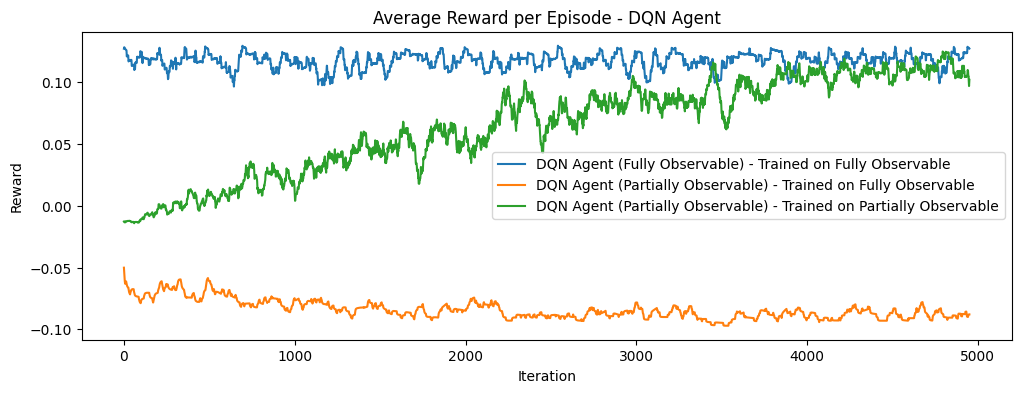

In [9]:
window = 50

def moving_average(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history_loaded, window), label='DQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_loaded_po, window), label='DQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_dqn_po, window), label='DQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Reward per Episode - DQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_dqn.png", bbox_inches='tight')
plt.show()
plt.close()

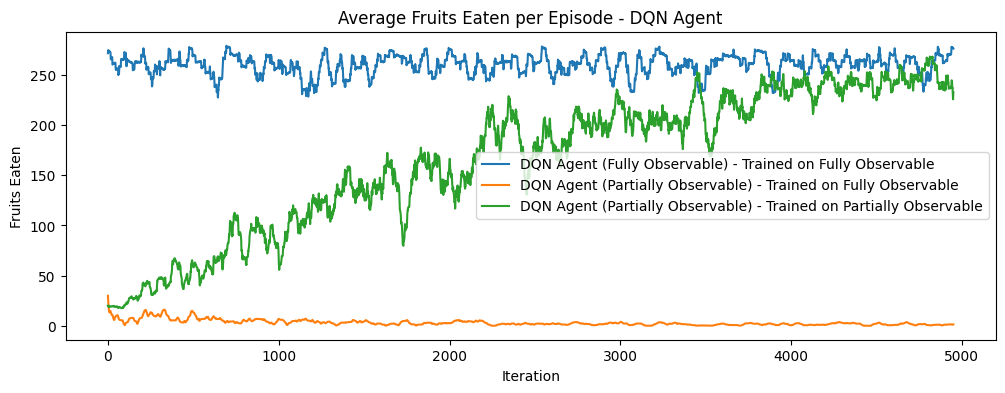

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_loaded, window), label='DQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_loaded_po, window), label='DQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_dqn_po, window), label='DQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Fruits Eaten per Episode - DQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten_dqn.png", bbox_inches='tight')
plt.show()
plt.close()

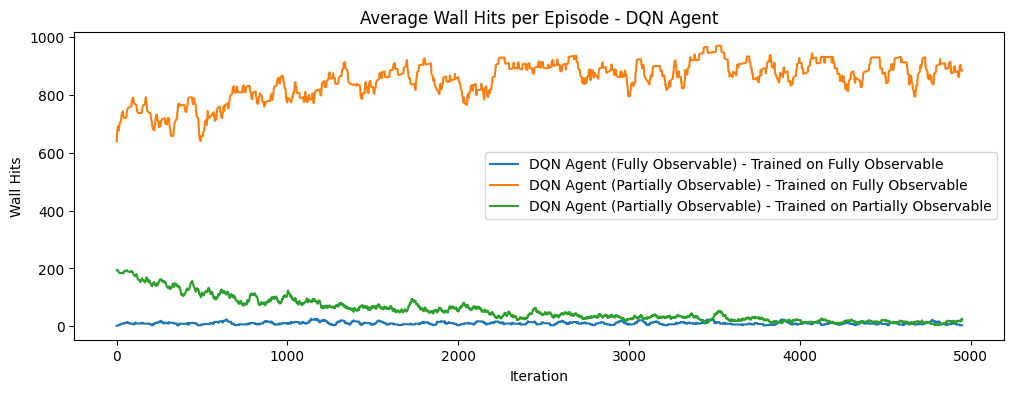

In [37]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits_loaded, window), label='DQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_loaded_po, window), label='DQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_dqn_po, window), label='DQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Wall Hits per Episode - DQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits_dqn.png", bbox_inches='tight')
plt.show()
plt.close()

## A2C Agent

### Training

In [29]:
from a2c import A2CAgent

env_ = get_env()
agent = A2CAgent(state_shape=env_.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)

rewards_history_ac, wall_hits_ac, fruits_eaten_ac, loss_history_ac = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_a2c_weights.h5")

  0%|          | 4/5000 [00:00<05:57, 13.98it/s]

Iteration 0: Avg Reward: -0.01, Avg Loss: 0.0175
Fruits eaten: 28, Max fruits eaten: 28
Wall hits: 192


  2%|▏         | 106/5000 [00:04<03:01, 26.90it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0069
Fruits eaten: 19, Max fruits eaten: 28
Wall hits: 215


  4%|▍         | 204/5000 [00:07<02:59, 26.69it/s]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0024
Fruits eaten: 23, Max fruits eaten: 28
Wall hits: 178


  6%|▌         | 306/5000 [00:11<02:50, 27.54it/s]

Iteration 300: Avg Reward: -0.01, Avg Loss: -0.0035
Fruits eaten: 20, Max fruits eaten: 28
Wall hits: 150


  8%|▊         | 406/5000 [00:15<02:46, 27.55it/s]

Iteration 400: Avg Reward: -0.01, Avg Loss: -0.0114
Fruits eaten: 24, Max fruits eaten: 28
Wall hits: 163


 10%|█         | 505/5000 [00:19<02:44, 27.31it/s]

Iteration 500: Avg Reward: -0.01, Avg Loss: -0.0197
Fruits eaten: 27, Max fruits eaten: 28
Wall hits: 113


 12%|█▏        | 605/5000 [00:23<03:02, 24.02it/s]

Iteration 600: Avg Reward: -0.01, Avg Loss: -0.0277
Fruits eaten: 24, Max fruits eaten: 28
Wall hits: 88


 14%|█▍        | 705/5000 [00:27<02:40, 26.79it/s]

Iteration 700: Avg Reward: -0.01, Avg Loss: -0.0330
Fruits eaten: 18, Max fruits eaten: 28
Wall hits: 99


 16%|█▌        | 804/5000 [00:31<02:34, 27.23it/s]

Iteration 800: Avg Reward: -0.00, Avg Loss: -0.0443
Fruits eaten: 23, Max fruits eaten: 28
Wall hits: 93


 18%|█▊        | 906/5000 [00:35<02:32, 26.79it/s]

Iteration 900: Avg Reward: 0.00, Avg Loss: -0.0483
Fruits eaten: 26, Max fruits eaten: 28
Wall hits: 89


 20%|██        | 1004/5000 [00:38<02:27, 27.17it/s]

Iteration 1000: Avg Reward: 0.00, Avg Loss: -0.0405
Fruits eaten: 22, Max fruits eaten: 28
Wall hits: 27


 22%|██▏       | 1106/5000 [00:42<02:39, 24.47it/s]

Iteration 1100: Avg Reward: 0.01, Avg Loss: -0.0412
Fruits eaten: 33, Max fruits eaten: 33
Wall hits: 20


 24%|██▍       | 1205/5000 [00:46<02:24, 26.33it/s]

Iteration 1200: Avg Reward: 0.01, Avg Loss: -0.0470
Fruits eaten: 46, Max fruits eaten: 46
Wall hits: 15


 26%|██▌       | 1304/5000 [00:50<02:25, 25.45it/s]

Iteration 1300: Avg Reward: 0.01, Avg Loss: -0.0507
Fruits eaten: 41, Max fruits eaten: 46
Wall hits: 3


 28%|██▊       | 1403/5000 [00:54<02:34, 23.31it/s]

Iteration 1400: Avg Reward: 0.02, Avg Loss: -0.0548
Fruits eaten: 45, Max fruits eaten: 46
Wall hits: 12


 30%|███       | 1505/5000 [00:59<02:29, 23.38it/s]

Iteration 1500: Avg Reward: 0.02, Avg Loss: -0.0492
Fruits eaten: 62, Max fruits eaten: 62
Wall hits: 14


 32%|███▏      | 1604/5000 [01:03<02:10, 25.93it/s]

Iteration 1600: Avg Reward: 0.02, Avg Loss: -0.0468
Fruits eaten: 58, Max fruits eaten: 62
Wall hits: 17


 34%|███▍      | 1703/5000 [01:07<02:28, 22.15it/s]

Iteration 1700: Avg Reward: 0.02, Avg Loss: -0.0448
Fruits eaten: 55, Max fruits eaten: 62
Wall hits: 12


 36%|███▌      | 1805/5000 [01:12<02:12, 24.20it/s]

Iteration 1800: Avg Reward: 0.02, Avg Loss: -0.0492
Fruits eaten: 36, Max fruits eaten: 62
Wall hits: 17


 38%|███▊      | 1904/5000 [01:16<02:07, 24.25it/s]

Iteration 1900: Avg Reward: 0.02, Avg Loss: -0.0491
Fruits eaten: 70, Max fruits eaten: 70
Wall hits: 17


 40%|████      | 2003/5000 [01:20<02:19, 21.49it/s]

Iteration 2000: Avg Reward: 0.02, Avg Loss: -0.0430
Fruits eaten: 68, Max fruits eaten: 70
Wall hits: 15


 42%|████▏     | 2105/5000 [01:25<02:07, 22.69it/s]

Iteration 2100: Avg Reward: 0.02, Avg Loss: -0.0476
Fruits eaten: 64, Max fruits eaten: 70
Wall hits: 20


 44%|████▍     | 2204/5000 [01:29<01:58, 23.68it/s]

Iteration 2200: Avg Reward: 0.03, Avg Loss: -0.0479
Fruits eaten: 65, Max fruits eaten: 70
Wall hits: 12


 46%|████▌     | 2305/5000 [01:33<01:52, 23.91it/s]

Iteration 2300: Avg Reward: 0.03, Avg Loss: -0.0454
Fruits eaten: 73, Max fruits eaten: 73
Wall hits: 17


 48%|████▊     | 2404/5000 [01:38<02:02, 21.13it/s]

Iteration 2400: Avg Reward: 0.03, Avg Loss: -0.0481
Fruits eaten: 78, Max fruits eaten: 78
Wall hits: 17


 50%|█████     | 2505/5000 [01:42<01:59, 20.83it/s]

Iteration 2500: Avg Reward: 0.03, Avg Loss: -0.0454
Fruits eaten: 70, Max fruits eaten: 78
Wall hits: 17


 52%|█████▏    | 2603/5000 [01:47<01:44, 23.04it/s]

Iteration 2600: Avg Reward: 0.03, Avg Loss: -0.0352
Fruits eaten: 74, Max fruits eaten: 78
Wall hits: 10


 54%|█████▍    | 2702/5000 [01:52<02:02, 18.69it/s]

Iteration 2700: Avg Reward: 0.03, Avg Loss: -0.0368
Fruits eaten: 71, Max fruits eaten: 78
Wall hits: 13


 56%|█████▌    | 2804/5000 [01:56<01:44, 21.05it/s]

Iteration 2800: Avg Reward: 0.03, Avg Loss: -0.0342
Fruits eaten: 68, Max fruits eaten: 78
Wall hits: 11


 58%|█████▊    | 2905/5000 [02:01<01:36, 21.78it/s]

Iteration 2900: Avg Reward: 0.04, Avg Loss: -0.0342
Fruits eaten: 83, Max fruits eaten: 83
Wall hits: 10


 60%|██████    | 3004/5000 [02:05<01:35, 21.00it/s]

Iteration 3000: Avg Reward: 0.04, Avg Loss: -0.0284
Fruits eaten: 117, Max fruits eaten: 117
Wall hits: 5


 62%|██████▏   | 3102/5000 [02:10<01:43, 18.42it/s]

Iteration 3100: Avg Reward: 0.04, Avg Loss: -0.0194
Fruits eaten: 112, Max fruits eaten: 117
Wall hits: 4


 64%|██████▍   | 3204/5000 [02:14<01:26, 20.85it/s]

Iteration 3200: Avg Reward: 0.04, Avg Loss: -0.0200
Fruits eaten: 91, Max fruits eaten: 117
Wall hits: 1


 66%|██████▌   | 3303/5000 [02:19<01:20, 21.16it/s]

Iteration 3300: Avg Reward: 0.04, Avg Loss: -0.0159
Fruits eaten: 94, Max fruits eaten: 117
Wall hits: 6


 68%|██████▊   | 3405/5000 [02:24<01:15, 21.25it/s]

Iteration 3400: Avg Reward: 0.05, Avg Loss: -0.0134
Fruits eaten: 114, Max fruits eaten: 117
Wall hits: 6


 70%|███████   | 3503/5000 [02:29<01:13, 20.41it/s]

Iteration 3500: Avg Reward: 0.05, Avg Loss: -0.0096
Fruits eaten: 100, Max fruits eaten: 117
Wall hits: 5


 72%|███████▏  | 3603/5000 [02:33<01:08, 20.49it/s]

Iteration 3600: Avg Reward: 0.05, Avg Loss: -0.0067
Fruits eaten: 101, Max fruits eaten: 117
Wall hits: 2


 74%|███████▍  | 3703/5000 [02:38<01:11, 18.06it/s]

Iteration 3700: Avg Reward: 0.05, Avg Loss: -0.0059
Fruits eaten: 120, Max fruits eaten: 120
Wall hits: 0


 76%|███████▌  | 3802/5000 [02:43<00:58, 20.53it/s]

Iteration 3800: Avg Reward: 0.06, Avg Loss: 0.0025
Fruits eaten: 113, Max fruits eaten: 120
Wall hits: 3


 78%|███████▊  | 3902/5000 [02:48<00:54, 20.31it/s]

Iteration 3900: Avg Reward: 0.06, Avg Loss: 0.0005
Fruits eaten: 114, Max fruits eaten: 120
Wall hits: 3


 80%|████████  | 4003/5000 [02:53<00:45, 21.85it/s]

Iteration 4000: Avg Reward: 0.06, Avg Loss: 0.0048
Fruits eaten: 148, Max fruits eaten: 148
Wall hits: 5


 82%|████████▏ | 4105/5000 [02:58<00:40, 22.20it/s]

Iteration 4100: Avg Reward: 0.06, Avg Loss: -0.0024
Fruits eaten: 108, Max fruits eaten: 148
Wall hits: 3


 84%|████████▍ | 4204/5000 [03:03<00:39, 20.08it/s]

Iteration 4200: Avg Reward: 0.06, Avg Loss: 0.0065
Fruits eaten: 138, Max fruits eaten: 148
Wall hits: 1


 86%|████████▌ | 4303/5000 [03:08<00:34, 19.96it/s]

Iteration 4300: Avg Reward: 0.06, Avg Loss: 0.0066
Fruits eaten: 149, Max fruits eaten: 149
Wall hits: 0


 88%|████████▊ | 4404/5000 [03:13<00:26, 22.26it/s]

Iteration 4400: Avg Reward: 0.06, Avg Loss: 0.0070
Fruits eaten: 141, Max fruits eaten: 149
Wall hits: 2


 90%|█████████ | 4503/5000 [03:18<00:23, 21.55it/s]

Iteration 4500: Avg Reward: 0.06, Avg Loss: 0.0092
Fruits eaten: 156, Max fruits eaten: 156
Wall hits: 2


 92%|█████████▏| 4604/5000 [03:23<00:21, 18.72it/s]

Iteration 4600: Avg Reward: 0.06, Avg Loss: 0.0174
Fruits eaten: 121, Max fruits eaten: 156
Wall hits: 2


 94%|█████████▍| 4703/5000 [03:27<00:15, 19.35it/s]

Iteration 4700: Avg Reward: 0.06, Avg Loss: 0.0113
Fruits eaten: 140, Max fruits eaten: 156
Wall hits: 4


 96%|█████████▌| 4805/5000 [03:32<00:09, 20.50it/s]

Iteration 4800: Avg Reward: 0.07, Avg Loss: 0.0165
Fruits eaten: 129, Max fruits eaten: 156
Wall hits: 2


 98%|█████████▊| 4904/5000 [03:37<00:04, 19.95it/s]

Iteration 4900: Avg Reward: 0.07, Avg Loss: 0.0140
Fruits eaten: 131, Max fruits eaten: 156
Wall hits: 1


100%|██████████| 5000/5000 [03:42<00:00, 22.45it/s]

Model weights saved to weights/snake_a2c_weights.h5
Weights saved to weights/snake_a2c_weights.h5


### Load the weights - A2C Agent

In [ ]:
env = get_env()
agent = A2CAgent(state_shape=env.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)
agent.load_weights("weights/snake_a2c_weights.h5")

rewards_history_loaded_ac = []
wall_hits_loaded_ac = []
fruits_eaten_loaded_ac = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ac.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ac.append(fruits_eaten_count)
    rewards_history_loaded_ac.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ac):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ac):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ac):.2f}")

Model weights loaded from weights/snake_a2c_weights.h5


100%|██████████| 5000/5000 [02:21<00:00, 35.43it/s]

Avg Reward: 0.07
Avg Wall Hits: 0.93
Avg Fruits Eaten: 141.21


### Load the weights - Testing on Partially Observable Environment

In [31]:
env = get_env(partially_observable=True)
agent = A2CAgent(state_shape=env.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)
agent.load_weights("weights/snake_a2c_weights.h5")

rewards_history_loaded_ac_po = []
wall_hits_loaded_ac_po = []
fruits_eaten_loaded_ac_po = []
loss_history_loaded_ac_po = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ac_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ac_po.append(fruits_eaten_count)
    rewards_history_loaded_ac_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ac_po):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ac_po):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ac_po):.2f}")

Model weights loaded from weights/snake_a2c_weights.h5


100%|██████████| 5000/5000 [01:52<00:00, 44.49it/s]

Avg Reward: -0.10
Avg Wall Hits: 962.07
Avg Fruits Eaten: 0.91


Here we train the model on the partially observable environment

In [32]:
env = get_env(partially_observable=True)
agent = A2CAgent(state_shape=env.to_state().shape[1:], n_actions=4, gamma=GAMMA, learning_rate=5e-5, entropy_beta=0.0001)

rewards_history_a2c_po, wall_hits_a2c_po, fruits_eaten_a2c_po, loss_history_a2c_po = training(ITERATIONS, env, agent, save_weights=True, save_path="weights/", file_name="snake_a2c_weights_po.h5")

  0%|          | 2/5000 [00:00<04:37, 18.01it/s]

Iteration 0: Avg Reward: -0.01, Avg Loss: 0.0091
Fruits eaten: 15, Max fruits eaten: 15
Wall hits: 205


  2%|▏         | 105/5000 [00:05<03:53, 20.92it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: -0.0023
Fruits eaten: 20, Max fruits eaten: 20
Wall hits: 123


  4%|▍         | 204/5000 [00:09<03:42, 21.59it/s]

Iteration 200: Avg Reward: -0.00, Avg Loss: -0.0225
Fruits eaten: 17, Max fruits eaten: 20
Wall hits: 47


  6%|▌         | 303/5000 [00:14<03:44, 20.97it/s]

Iteration 300: Avg Reward: 0.00, Avg Loss: -0.0332
Fruits eaten: 24, Max fruits eaten: 24
Wall hits: 20


  8%|▊         | 404/5000 [00:19<04:00, 19.09it/s]

Iteration 400: Avg Reward: 0.01, Avg Loss: -0.0592
Fruits eaten: 31, Max fruits eaten: 31
Wall hits: 23


 10%|█         | 505/5000 [00:24<03:41, 20.29it/s]

Iteration 500: Avg Reward: 0.01, Avg Loss: -0.0852
Fruits eaten: 40, Max fruits eaten: 40
Wall hits: 15


 12%|█▏        | 602/5000 [00:29<03:50, 19.07it/s]

Iteration 600: Avg Reward: 0.02, Avg Loss: -0.0872
Fruits eaten: 48, Max fruits eaten: 48
Wall hits: 17


 14%|█▍        | 704/5000 [00:35<03:46, 18.95it/s]

Iteration 700: Avg Reward: 0.03, Avg Loss: -0.0741
Fruits eaten: 65, Max fruits eaten: 65
Wall hits: 11


 16%|█▌        | 803/5000 [00:40<03:53, 18.00it/s]

Iteration 800: Avg Reward: 0.03, Avg Loss: -0.0468
Fruits eaten: 68, Max fruits eaten: 68
Wall hits: 23


 18%|█▊        | 903/5000 [00:45<03:50, 17.79it/s]

Iteration 900: Avg Reward: 0.03, Avg Loss: -0.0351
Fruits eaten: 59, Max fruits eaten: 68
Wall hits: 14


 20%|██        | 1003/5000 [00:51<03:55, 16.95it/s]

Iteration 1000: Avg Reward: 0.03, Avg Loss: -0.0245
Fruits eaten: 85, Max fruits eaten: 85
Wall hits: 17


 22%|██▏       | 1103/5000 [00:57<03:40, 17.67it/s]

Iteration 1100: Avg Reward: 0.03, Avg Loss: -0.0158
Fruits eaten: 71, Max fruits eaten: 85
Wall hits: 22


 24%|██▍       | 1203/5000 [01:02<03:46, 16.76it/s]

Iteration 1200: Avg Reward: 0.03, Avg Loss: -0.0183
Fruits eaten: 79, Max fruits eaten: 85
Wall hits: 31


 26%|██▌       | 1303/5000 [01:08<03:16, 18.78it/s]

Iteration 1300: Avg Reward: 0.03, Avg Loss: -0.0077
Fruits eaten: 93, Max fruits eaten: 93
Wall hits: 38


 28%|██▊       | 1403/5000 [01:13<03:15, 18.43it/s]

Iteration 1400: Avg Reward: 0.03, Avg Loss: -0.0069
Fruits eaten: 56, Max fruits eaten: 93
Wall hits: 51


 30%|███       | 1503/5000 [01:19<03:08, 18.55it/s]

Iteration 1500: Avg Reward: 0.03, Avg Loss: -0.0057
Fruits eaten: 77, Max fruits eaten: 93
Wall hits: 42


 32%|███▏      | 1603/5000 [01:24<03:00, 18.83it/s]

Iteration 1600: Avg Reward: 0.03, Avg Loss: -0.0053
Fruits eaten: 71, Max fruits eaten: 93
Wall hits: 39


 34%|███▍      | 1703/5000 [01:29<02:56, 18.72it/s]

Iteration 1700: Avg Reward: 0.03, Avg Loss: 0.0035
Fruits eaten: 77, Max fruits eaten: 93
Wall hits: 51


 36%|███▌      | 1804/5000 [01:35<02:58, 17.93it/s]

Iteration 1800: Avg Reward: 0.03, Avg Loss: 0.0010
Fruits eaten: 63, Max fruits eaten: 93
Wall hits: 57


 38%|███▊      | 1903/5000 [01:41<02:51, 18.10it/s]

Iteration 1900: Avg Reward: 0.03, Avg Loss: 0.0088
Fruits eaten: 71, Max fruits eaten: 93
Wall hits: 55


 40%|████      | 2003/5000 [01:46<02:50, 17.55it/s]

Iteration 2000: Avg Reward: 0.03, Avg Loss: 0.0047
Fruits eaten: 73, Max fruits eaten: 93
Wall hits: 60


 42%|████▏     | 2103/5000 [01:52<02:38, 18.30it/s]

Iteration 2100: Avg Reward: 0.02, Avg Loss: 0.0064
Fruits eaten: 67, Max fruits eaten: 93
Wall hits: 70


 44%|████▍     | 2203/5000 [01:57<02:32, 18.33it/s]

Iteration 2200: Avg Reward: 0.02, Avg Loss: 0.0043
Fruits eaten: 61, Max fruits eaten: 93
Wall hits: 44


 46%|████▌     | 2303/5000 [02:03<02:45, 16.31it/s]

Iteration 2300: Avg Reward: 0.03, Avg Loss: 0.0117
Fruits eaten: 76, Max fruits eaten: 93
Wall hits: 58


 48%|████▊     | 2403/5000 [02:08<02:19, 18.64it/s]

Iteration 2400: Avg Reward: 0.02, Avg Loss: 0.0091
Fruits eaten: 41, Max fruits eaten: 93
Wall hits: 58


 50%|█████     | 2504/5000 [02:14<02:16, 18.25it/s]

Iteration 2500: Avg Reward: 0.03, Avg Loss: 0.0135
Fruits eaten: 75, Max fruits eaten: 93
Wall hits: 56


 52%|█████▏    | 2604/5000 [02:20<02:11, 18.15it/s]

Iteration 2600: Avg Reward: 0.02, Avg Loss: 0.0080
Fruits eaten: 52, Max fruits eaten: 93
Wall hits: 71


 54%|█████▍    | 2703/5000 [02:25<02:22, 16.08it/s]

Iteration 2700: Avg Reward: 0.02, Avg Loss: 0.0061
Fruits eaten: 53, Max fruits eaten: 93
Wall hits: 55


 56%|█████▌    | 2804/5000 [02:30<02:07, 17.17it/s]

Iteration 2800: Avg Reward: 0.01, Avg Loss: 0.0033
Fruits eaten: 35, Max fruits eaten: 93
Wall hits: 63


 58%|█████▊    | 2904/5000 [02:36<01:56, 17.98it/s]

Iteration 2900: Avg Reward: 0.01, Avg Loss: 0.0043
Fruits eaten: 27, Max fruits eaten: 93
Wall hits: 50


 60%|██████    | 3003/5000 [02:41<01:48, 18.34it/s]

Iteration 3000: Avg Reward: 0.02, Avg Loss: 0.0073
Fruits eaten: 35, Max fruits eaten: 93
Wall hits: 49


 62%|██████▏   | 3103/5000 [02:46<01:44, 18.10it/s]

Iteration 3100: Avg Reward: 0.02, Avg Loss: 0.0139
Fruits eaten: 44, Max fruits eaten: 93
Wall hits: 52


 64%|██████▍   | 3204/5000 [02:52<01:38, 18.31it/s]

Iteration 3200: Avg Reward: 0.01, Avg Loss: 0.0061
Fruits eaten: 56, Max fruits eaten: 93
Wall hits: 54


 66%|██████▌   | 3304/5000 [02:57<01:30, 18.74it/s]

Iteration 3300: Avg Reward: 0.01, Avg Loss: 0.0066
Fruits eaten: 28, Max fruits eaten: 93
Wall hits: 57


 68%|██████▊   | 3403/5000 [03:02<01:26, 18.36it/s]

Iteration 3400: Avg Reward: 0.01, Avg Loss: 0.0036
Fruits eaten: 46, Max fruits eaten: 93
Wall hits: 47


 70%|███████   | 3503/5000 [03:08<01:20, 18.58it/s]

Iteration 3500: Avg Reward: 0.02, Avg Loss: 0.0058
Fruits eaten: 69, Max fruits eaten: 93
Wall hits: 49


 72%|███████▏  | 3604/5000 [03:14<01:17, 18.04it/s]

Iteration 3600: Avg Reward: 0.02, Avg Loss: 0.0151
Fruits eaten: 50, Max fruits eaten: 93
Wall hits: 68


 74%|███████▍  | 3704/5000 [03:19<01:12, 17.82it/s]

Iteration 3700: Avg Reward: 0.02, Avg Loss: 0.0113
Fruits eaten: 46, Max fruits eaten: 93
Wall hits: 93


 76%|███████▌  | 3804/5000 [03:25<01:04, 18.46it/s]

Iteration 3800: Avg Reward: 0.01, Avg Loss: 0.0063
Fruits eaten: 46, Max fruits eaten: 93
Wall hits: 68


 78%|███████▊  | 3903/5000 [03:30<00:58, 18.76it/s]

Iteration 3900: Avg Reward: 0.01, Avg Loss: 0.0051
Fruits eaten: 26, Max fruits eaten: 93
Wall hits: 72


 80%|████████  | 4004/5000 [03:35<00:52, 18.87it/s]

Iteration 4000: Avg Reward: 0.01, Avg Loss: 0.0033
Fruits eaten: 27, Max fruits eaten: 93
Wall hits: 43


 82%|████████▏ | 4103/5000 [03:41<00:49, 18.01it/s]

Iteration 4100: Avg Reward: 0.02, Avg Loss: 0.0068
Fruits eaten: 61, Max fruits eaten: 93
Wall hits: 59


 84%|████████▍ | 4203/5000 [03:47<00:43, 18.20it/s]

Iteration 4200: Avg Reward: 0.02, Avg Loss: 0.0174
Fruits eaten: 61, Max fruits eaten: 93
Wall hits: 70


 86%|████████▌ | 4304/5000 [03:52<00:37, 18.79it/s]

Iteration 4300: Avg Reward: 0.02, Avg Loss: 0.0099
Fruits eaten: 62, Max fruits eaten: 93
Wall hits: 81


 88%|████████▊ | 4403/5000 [03:58<00:33, 17.90it/s]

Iteration 4400: Avg Reward: 0.02, Avg Loss: 0.0136
Fruits eaten: 67, Max fruits eaten: 93
Wall hits: 72


 90%|█████████ | 4504/5000 [04:03<00:27, 18.18it/s]

Iteration 4500: Avg Reward: 0.02, Avg Loss: 0.0101
Fruits eaten: 44, Max fruits eaten: 93
Wall hits: 102


 92%|█████████▏| 4604/5000 [04:09<00:20, 19.09it/s]

Iteration 4600: Avg Reward: 0.01, Avg Loss: 0.0040
Fruits eaten: 50, Max fruits eaten: 93
Wall hits: 58


 94%|█████████▍| 4703/5000 [04:14<00:17, 17.36it/s]

Iteration 4700: Avg Reward: 0.02, Avg Loss: 0.0114
Fruits eaten: 68, Max fruits eaten: 93
Wall hits: 67


 96%|█████████▌| 4804/5000 [04:20<00:10, 18.58it/s]

Iteration 4800: Avg Reward: 0.01, Avg Loss: 0.0045
Fruits eaten: 49, Max fruits eaten: 93
Wall hits: 68


 98%|█████████▊| 4903/5000 [04:25<00:05, 17.85it/s]

Iteration 4900: Avg Reward: 0.01, Avg Loss: -0.0011
Fruits eaten: 34, Max fruits eaten: 93
Wall hits: 77


100%|██████████| 5000/5000 [04:30<00:00, 18.47it/s]

Model weights saved to weights/snake_a2c_weights_po.h5
Weights saved to weights/snake_a2c_weights_po.h5


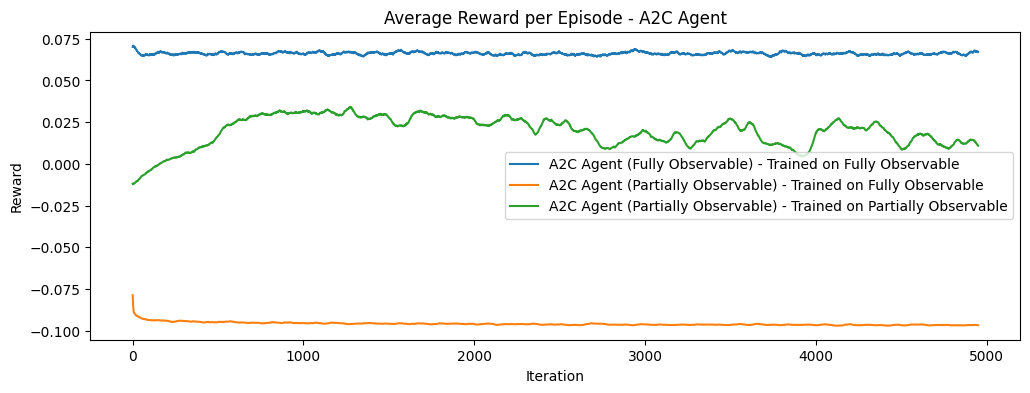

In [33]:
plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history_loaded_ac, window), label='A2C Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_loaded_ac_po, window), label='A2C Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_a2c_po, window), label='A2C Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Reward per Episode - A2C Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_a2c.png", bbox_inches='tight')
plt.show()
plt.close()

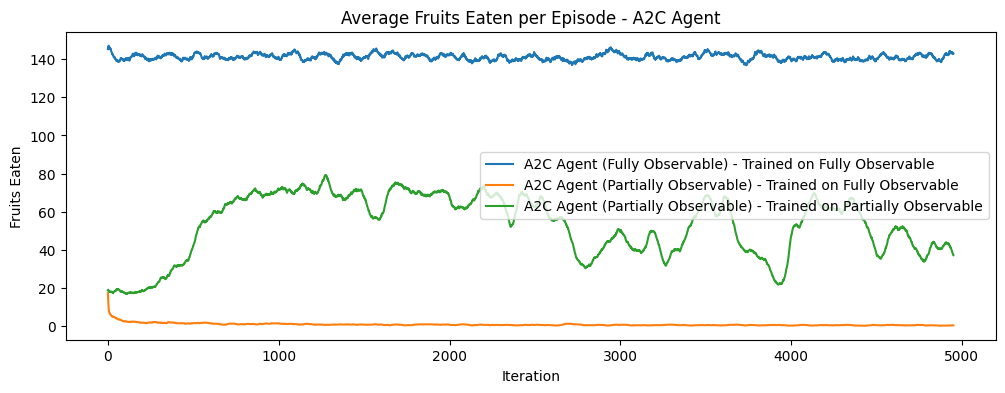

In [34]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_loaded_ac, window), label='A2C Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_loaded_ac_po, window), label='A2C Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_a2c_po, window), label='A2C Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Fruits Eaten per Episode - A2C Agent')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten_a2c.png", bbox_inches='tight')
plt.show()
plt.close()

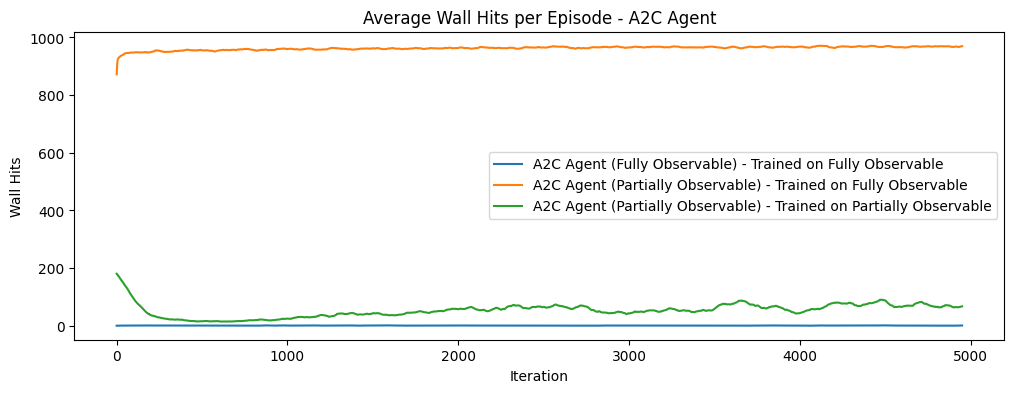

In [35]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits_loaded_ac, window), label='A2C Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_loaded_ac_po, window), label='A2C Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_a2c_po, window), label='A2C Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Wall Hits per Episode - A2C Agent')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits_a2c.png", bbox_inches='tight')
plt.show()
plt.close()

## Double DQN

### Training

In [40]:
from ddqn import DoubleDQNAgent

env_ = get_env()
agent = DoubleDQNAgent(state_shape=env_.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)

rewards_history_ddqn, wall_hits_ddqn, fruits_eaten_ddqn, loss_history_ddqn = training(ITERATIONS, env_, agent, save_weights=True, save_path="weights/", file_name="snake_ddqn_weights.h5")

  0%|          | 1/5000 [00:01<2:16:54,  1.64s/it]

Iteration 0: Avg Reward: -0.00, Avg Loss: 0.0217
Fruits eaten: 31, Max fruits eaten: 31
Wall hits: 177


  2%|▏         | 101/5000 [01:52<1:21:19,  1.00it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0122
Fruits eaten: 19, Max fruits eaten: 31
Wall hits: 199


  4%|▍         | 201/5000 [03:42<1:24:43,  1.06s/it]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0072
Fruits eaten: 16, Max fruits eaten: 31
Wall hits: 184


  6%|▌         | 301/5000 [05:28<1:24:52,  1.08s/it]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0058
Fruits eaten: 17, Max fruits eaten: 31
Wall hits: 192


  8%|▊         | 401/5000 [07:20<1:20:29,  1.05s/it]

Iteration 400: Avg Reward: -0.01, Avg Loss: 0.0061
Fruits eaten: 22, Max fruits eaten: 31
Wall hits: 122


 10%|█         | 501/5000 [09:07<1:15:58,  1.01s/it]

Iteration 500: Avg Reward: -0.01, Avg Loss: 0.0074
Fruits eaten: 59, Max fruits eaten: 59
Wall hits: 1


 12%|█▏        | 601/5000 [10:57<1:19:31,  1.08s/it]

Iteration 600: Avg Reward: -0.01, Avg Loss: 0.0074
Fruits eaten: 17, Max fruits eaten: 59
Wall hits: 189


 14%|█▍        | 701/5000 [12:51<1:16:28,  1.07s/it]

Iteration 700: Avg Reward: 0.00, Avg Loss: 0.0089
Fruits eaten: 39, Max fruits eaten: 59
Wall hits: 175


 16%|█▌        | 801/5000 [14:38<1:14:26,  1.06s/it]

Iteration 800: Avg Reward: 0.01, Avg Loss: 0.0095
Fruits eaten: 20, Max fruits eaten: 59
Wall hits: 219


 18%|█▊        | 901/5000 [16:22<1:16:17,  1.12s/it]

Iteration 900: Avg Reward: 0.01, Avg Loss: 0.0090
Fruits eaten: 179, Max fruits eaten: 179
Wall hits: 0


 20%|██        | 1001/5000 [18:03<1:05:37,  1.02it/s]

Iteration 1000: Avg Reward: 0.02, Avg Loss: 0.0106
Fruits eaten: 63, Max fruits eaten: 179
Wall hits: 166


 22%|██▏       | 1101/5000 [19:46<1:08:36,  1.06s/it]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0118
Fruits eaten: 188, Max fruits eaten: 188
Wall hits: 1


 24%|██▍       | 1201/5000 [21:31<1:06:11,  1.05s/it]

Iteration 1200: Avg Reward: 0.03, Avg Loss: 0.0153
Fruits eaten: 305, Max fruits eaten: 305
Wall hits: 0


 26%|██▌       | 1301/5000 [23:19<1:05:21,  1.06s/it]

Iteration 1300: Avg Reward: 0.04, Avg Loss: 0.0184
Fruits eaten: 276, Max fruits eaten: 305
Wall hits: 3


 28%|██▊       | 1401/5000 [25:04<59:40,  1.01it/s]  

Iteration 1400: Avg Reward: 0.03, Avg Loss: 0.0226
Fruits eaten: 103, Max fruits eaten: 305
Wall hits: 1


 30%|███       | 1501/5000 [26:45<1:02:34,  1.07s/it]

Iteration 1500: Avg Reward: 0.05, Avg Loss: 0.0256
Fruits eaten: 338, Max fruits eaten: 338
Wall hits: 2


 32%|███▏      | 1601/5000 [28:29<59:49,  1.06s/it]  

Iteration 1600: Avg Reward: 0.04, Avg Loss: 0.0259
Fruits eaten: 139, Max fruits eaten: 338
Wall hits: 3


 34%|███▍      | 1701/5000 [30:15<58:26,  1.06s/it]  

Iteration 1700: Avg Reward: 0.06, Avg Loss: 0.0259
Fruits eaten: 272, Max fruits eaten: 338
Wall hits: 6


 36%|███▌      | 1801/5000 [32:02<1:07:45,  1.27s/it]

Iteration 1800: Avg Reward: 0.06, Avg Loss: 0.0313
Fruits eaten: 78, Max fruits eaten: 338
Wall hits: 125


 38%|███▊      | 1901/5000 [34:04<1:02:11,  1.20s/it]

Iteration 1900: Avg Reward: 0.05, Avg Loss: 0.0332
Fruits eaten: 156, Max fruits eaten: 338
Wall hits: 2


 40%|████      | 2001/5000 [35:50<46:34,  1.07it/s]  

Iteration 2000: Avg Reward: 0.05, Avg Loss: 0.0357
Fruits eaten: 263, Max fruits eaten: 338
Wall hits: 3


 42%|████▏     | 2101/5000 [37:33<44:03,  1.10it/s]

Iteration 2100: Avg Reward: 0.06, Avg Loss: 0.0366
Fruits eaten: 139, Max fruits eaten: 338
Wall hits: 5


 44%|████▍     | 2201/5000 [39:19<49:41,  1.07s/it]  

Iteration 2200: Avg Reward: 0.05, Avg Loss: 0.0398
Fruits eaten: 73, Max fruits eaten: 338
Wall hits: 119


 46%|████▌     | 2301/5000 [41:08<46:16,  1.03s/it]

Iteration 2300: Avg Reward: 0.07, Avg Loss: 0.0346
Fruits eaten: 269, Max fruits eaten: 338
Wall hits: 3


 48%|████▊     | 2401/5000 [42:50<46:44,  1.08s/it]

Iteration 2400: Avg Reward: 0.08, Avg Loss: 0.0264
Fruits eaten: 293, Max fruits eaten: 338
Wall hits: 3


 50%|█████     | 2501/5000 [44:32<40:56,  1.02it/s]

Iteration 2500: Avg Reward: 0.07, Avg Loss: 0.0338
Fruits eaten: 327, Max fruits eaten: 338
Wall hits: 2


 52%|█████▏    | 2601/5000 [46:11<39:16,  1.02it/s]

Iteration 2600: Avg Reward: 0.08, Avg Loss: 0.0313
Fruits eaten: 77, Max fruits eaten: 338
Wall hits: 153


 54%|█████▍    | 2701/5000 [47:54<39:38,  1.03s/it]

Iteration 2700: Avg Reward: 0.08, Avg Loss: 0.0352
Fruits eaten: 79, Max fruits eaten: 338
Wall hits: 124


 56%|█████▌    | 2801/5000 [49:38<38:44,  1.06s/it]

Iteration 2800: Avg Reward: 0.08, Avg Loss: 0.0352
Fruits eaten: 71, Max fruits eaten: 338
Wall hits: 131


 58%|█████▊    | 2901/5000 [51:22<36:45,  1.05s/it]

Iteration 2900: Avg Reward: 0.09, Avg Loss: 0.0315
Fruits eaten: 270, Max fruits eaten: 338
Wall hits: 3


 60%|██████    | 3001/5000 [53:07<34:40,  1.04s/it]

Iteration 3000: Avg Reward: 0.09, Avg Loss: 0.0358
Fruits eaten: 132, Max fruits eaten: 338
Wall hits: 2


 62%|██████▏   | 3101/5000 [54:50<31:13,  1.01it/s]

Iteration 3100: Avg Reward: 0.08, Avg Loss: 0.0460
Fruits eaten: 69, Max fruits eaten: 338
Wall hits: 101


 64%|██████▍   | 3201/5000 [56:29<30:03,  1.00s/it]

Iteration 3200: Avg Reward: 0.08, Avg Loss: 0.0440
Fruits eaten: 52, Max fruits eaten: 338
Wall hits: 124


 66%|██████▌   | 3301/5000 [58:08<27:53,  1.02it/s]

Iteration 3300: Avg Reward: 0.08, Avg Loss: 0.0449
Fruits eaten: 138, Max fruits eaten: 338
Wall hits: 3


 68%|██████▊   | 3401/5000 [59:50<27:43,  1.04s/it]

Iteration 3400: Avg Reward: 0.08, Avg Loss: 0.0403
Fruits eaten: 79, Max fruits eaten: 338
Wall hits: 143


 70%|███████   | 3501/5000 [1:01:32<25:10,  1.01s/it]

Iteration 3500: Avg Reward: 0.09, Avg Loss: 0.0418
Fruits eaten: 283, Max fruits eaten: 338
Wall hits: 3


 72%|███████▏  | 3601/5000 [1:03:10<22:54,  1.02it/s]

Iteration 3600: Avg Reward: 0.10, Avg Loss: 0.0356
Fruits eaten: 249, Max fruits eaten: 338
Wall hits: 4


 74%|███████▍  | 3701/5000 [1:04:50<22:29,  1.04s/it]

Iteration 3700: Avg Reward: 0.10, Avg Loss: 0.0355
Fruits eaten: 298, Max fruits eaten: 338
Wall hits: 6


 76%|███████▌  | 3801/5000 [1:06:31<19:53,  1.00it/s]

Iteration 3800: Avg Reward: 0.10, Avg Loss: 0.0340
Fruits eaten: 134, Max fruits eaten: 338
Wall hits: 0


 78%|███████▊  | 3901/5000 [1:08:10<18:04,  1.01it/s]

Iteration 3900: Avg Reward: 0.10, Avg Loss: 0.0320
Fruits eaten: 295, Max fruits eaten: 338
Wall hits: 1


 80%|████████  | 4001/5000 [1:09:49<16:29,  1.01it/s]

Iteration 4000: Avg Reward: 0.09, Avg Loss: 0.0385
Fruits eaten: 282, Max fruits eaten: 338
Wall hits: 5


 82%|████████▏ | 4101/5000 [1:11:28<14:46,  1.01it/s]

Iteration 4100: Avg Reward: 0.11, Avg Loss: 0.0341
Fruits eaten: 275, Max fruits eaten: 338
Wall hits: 2


 84%|████████▍ | 4201/5000 [1:13:09<13:46,  1.03s/it]

Iteration 4200: Avg Reward: 0.10, Avg Loss: 0.0394
Fruits eaten: 300, Max fruits eaten: 338
Wall hits: 0


 86%|████████▌ | 4301/5000 [1:14:53<11:56,  1.02s/it]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0410
Fruits eaten: 324, Max fruits eaten: 338
Wall hits: 1


 88%|████████▊ | 4401/5000 [1:16:32<09:48,  1.02it/s]

Iteration 4400: Avg Reward: 0.11, Avg Loss: 0.0407
Fruits eaten: 284, Max fruits eaten: 338
Wall hits: 2


 90%|█████████ | 4501/5000 [1:18:10<08:10,  1.02it/s]

Iteration 4500: Avg Reward: 0.11, Avg Loss: 0.0394
Fruits eaten: 347, Max fruits eaten: 347
Wall hits: 0


 92%|█████████▏| 4601/5000 [1:19:49<06:33,  1.01it/s]

Iteration 4600: Avg Reward: 0.11, Avg Loss: 0.0466
Fruits eaten: 288, Max fruits eaten: 347
Wall hits: 1


 94%|█████████▍| 4701/5000 [1:21:27<04:53,  1.02it/s]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0386
Fruits eaten: 72, Max fruits eaten: 347
Wall hits: 147


 96%|█████████▌| 4801/5000 [1:23:08<03:27,  1.04s/it]

Iteration 4800: Avg Reward: 0.11, Avg Loss: 0.0495
Fruits eaten: 291, Max fruits eaten: 347
Wall hits: 0


 98%|█████████▊| 4901/5000 [1:24:51<01:43,  1.04s/it]

Iteration 4900: Avg Reward: 0.11, Avg Loss: 0.0367
Fruits eaten: 275, Max fruits eaten: 347
Wall hits: 0


100%|██████████| 5000/5000 [1:26:33<00:00,  1.04s/it]


Model weights saved to weights/snake_ddqn_weights.h5
Weights saved to weights/snake_ddqn_weights.h5


### Load the weights - DDQN Agent

In [ ]:
from ddqn import DoubleDQNAgent

env = get_env()
agent = DoubleDQNAgent(state_shape=env.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)
agent.load_weights("weights/snake_ddqn_weights.h5")

rewards_history_loaded_ddqn = []
wall_hits_loaded_ddqn = []
fruits_eaten_loaded_ddqn = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ddqn.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ddqn.append(fruits_eaten_count)
    rewards_history_loaded_ddqn.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ddqn):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ddqn):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ddqn):.2f}")

Model weights loaded from weights/snake_ddqn_weights.h5


100%|██████████| 5000/5000 [02:40<00:00, 31.11it/s]

Avg Reward: 0.11
Avg Wall Hits: 16.34
Avg Fruits Eaten: 247.15


### Load the weights - Testing on Partially Observable Environment

In [17]:
env = get_env(partially_observable=True)
agent = DoubleDQNAgent(state_shape=env.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)
agent.load_weights("weights/snake_ddqn_weights.h5")

rewards_history_loaded_ddqn_po = []
wall_hits_loaded_ddqn_po = []
fruits_eaten_loaded_ddqn_po = []
loss_history_loaded_ddqn_po = []

for iteration in trange(ITERATIONS):
    state = tf.constant(env.to_state())
    actions = agent.select_action(state)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_loaded_ddqn_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_loaded_ddqn_po.append(fruits_eaten_count)
    rewards_history_loaded_ddqn_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

print(f"Avg Reward: {np.mean(rewards_history_loaded_ddqn_po):.2f}")
print(f"Avg Wall Hits: {np.mean(wall_hits_loaded_ddqn_po):.2f}")
print(f"Avg Fruits Eaten: {np.mean(fruits_eaten_loaded_ddqn_po):.2f}")

Model weights loaded from weights/snake_ddqn_weights.h5


100%|██████████| 5000/5000 [01:35<00:00, 52.10it/s]

Avg Reward: -0.02
Avg Wall Hits: 199.57
Avg Fruits Eaten: 2.72


Here we train the model on the partially observable environment

In [18]:
env = get_env(partially_observable=True)
agent = DoubleDQNAgent(state_shape=env.to_state().shape[1:], n_actions=4, buffer_size=10000, batch_size=128, epsilon_start=1., epsilon_end=0.1, epsilon_decay=0.9995, learning_rate=1e-4, gamma=GAMMA, target_update_freq=100)

rewards_history_ddqn_po, wall_hits_ddqn_po, fruits_eaten_ddqn_po, loss_history_ddqn_po = training(ITERATIONS, env, agent, save_weights=True, save_path="weights/", file_name="snake_ddqn_weights_po.h5")

  0%|          | 1/5000 [00:01<1:58:18,  1.42s/it]

Iteration 0: Avg Reward: -0.00, Avg Loss: 0.0213
Fruits eaten: 37, Max fruits eaten: 37
Wall hits: 197


  2%|▏         | 101/5000 [01:38<1:18:42,  1.04it/s]

Iteration 100: Avg Reward: -0.01, Avg Loss: 0.0116
Fruits eaten: 24, Max fruits eaten: 37
Wall hits: 186


  4%|▍         | 201/5000 [03:15<1:18:23,  1.02it/s]

Iteration 200: Avg Reward: -0.01, Avg Loss: 0.0050
Fruits eaten: 12, Max fruits eaten: 37
Wall hits: 170


  6%|▌         | 301/5000 [04:52<1:16:39,  1.02it/s]

Iteration 300: Avg Reward: -0.01, Avg Loss: 0.0040
Fruits eaten: 13, Max fruits eaten: 37
Wall hits: 206


  8%|▊         | 401/5000 [06:30<1:16:28,  1.00it/s]

Iteration 400: Avg Reward: -0.00, Avg Loss: 0.0070
Fruits eaten: 40, Max fruits eaten: 40
Wall hits: 155


 10%|█         | 501/5000 [08:13<1:19:02,  1.05s/it]

Iteration 500: Avg Reward: 0.00, Avg Loss: 0.0122
Fruits eaten: 15, Max fruits eaten: 40
Wall hits: 184


 12%|█▏        | 601/5000 [09:58<1:17:33,  1.06s/it]

Iteration 600: Avg Reward: 0.01, Avg Loss: 0.0161
Fruits eaten: 266, Max fruits eaten: 266
Wall hits: 4


 14%|█▍        | 701/5000 [11:44<1:19:11,  1.11s/it]

Iteration 700: Avg Reward: 0.02, Avg Loss: 0.0218
Fruits eaten: 35, Max fruits eaten: 266
Wall hits: 150


 16%|█▌        | 801/5000 [13:30<1:14:26,  1.06s/it]

Iteration 800: Avg Reward: 0.02, Avg Loss: 0.0219
Fruits eaten: 137, Max fruits eaten: 266
Wall hits: 2


 18%|█▊        | 901/5000 [15:14<1:09:52,  1.02s/it]

Iteration 900: Avg Reward: 0.02, Avg Loss: 0.0288
Fruits eaten: 116, Max fruits eaten: 266
Wall hits: 1


 20%|██        | 1001/5000 [16:52<1:04:57,  1.03it/s]

Iteration 1000: Avg Reward: 0.02, Avg Loss: 0.0316
Fruits eaten: 30, Max fruits eaten: 266
Wall hits: 166


 22%|██▏       | 1101/5000 [18:31<1:03:15,  1.03it/s]

Iteration 1100: Avg Reward: 0.02, Avg Loss: 0.0320
Fruits eaten: 79, Max fruits eaten: 266
Wall hits: 119


 24%|██▍       | 1201/5000 [20:08<1:01:08,  1.04it/s]

Iteration 1200: Avg Reward: 0.02, Avg Loss: 0.0332
Fruits eaten: 31, Max fruits eaten: 266
Wall hits: 168


 26%|██▌       | 1301/5000 [21:46<1:02:35,  1.02s/it]

Iteration 1300: Avg Reward: 0.03, Avg Loss: 0.0343
Fruits eaten: 24, Max fruits eaten: 266
Wall hits: 172


 28%|██▊       | 1401/5000 [23:25<59:11,  1.01it/s]  

Iteration 1400: Avg Reward: 0.04, Avg Loss: 0.0378
Fruits eaten: 331, Max fruits eaten: 331
Wall hits: 2


 30%|███       | 1501/5000 [25:02<56:58,  1.02it/s]

Iteration 1500: Avg Reward: 0.04, Avg Loss: 0.0354
Fruits eaten: 305, Max fruits eaten: 331
Wall hits: 6


 32%|███▏      | 1601/5000 [26:41<57:41,  1.02s/it]

Iteration 1600: Avg Reward: 0.05, Avg Loss: 0.0323
Fruits eaten: 69, Max fruits eaten: 331
Wall hits: 120


 34%|███▍      | 1701/5000 [28:20<54:10,  1.01it/s]

Iteration 1700: Avg Reward: 0.05, Avg Loss: 0.0349
Fruits eaten: 78, Max fruits eaten: 331
Wall hits: 121


 36%|███▌      | 1801/5000 [29:58<52:23,  1.02it/s]

Iteration 1800: Avg Reward: 0.06, Avg Loss: 0.0355
Fruits eaten: 120, Max fruits eaten: 331
Wall hits: 1


 38%|███▊      | 1901/5000 [31:38<58:00,  1.12s/it]  

Iteration 1900: Avg Reward: 0.05, Avg Loss: 0.0353
Fruits eaten: 41, Max fruits eaten: 331
Wall hits: 170


 40%|████      | 2001/5000 [33:18<49:45,  1.00it/s]

Iteration 2000: Avg Reward: 0.07, Avg Loss: 0.0267
Fruits eaten: 60, Max fruits eaten: 331
Wall hits: 119


 42%|████▏     | 2101/5000 [34:56<46:33,  1.04it/s]

Iteration 2100: Avg Reward: 0.06, Avg Loss: 0.0335
Fruits eaten: 86, Max fruits eaten: 331
Wall hits: 2


 44%|████▍     | 2201/5000 [36:34<46:17,  1.01it/s]

Iteration 2200: Avg Reward: 0.07, Avg Loss: 0.0316
Fruits eaten: 161, Max fruits eaten: 331
Wall hits: 1


 46%|████▌     | 2301/5000 [38:14<46:56,  1.04s/it]

Iteration 2300: Avg Reward: 0.07, Avg Loss: 0.0305
Fruits eaten: 290, Max fruits eaten: 331
Wall hits: 4


 48%|████▊     | 2401/5000 [39:52<42:43,  1.01it/s]

Iteration 2400: Avg Reward: 0.07, Avg Loss: 0.0402
Fruits eaten: 141, Max fruits eaten: 331
Wall hits: 1


 50%|█████     | 2501/5000 [41:30<40:28,  1.03it/s]

Iteration 2500: Avg Reward: 0.08, Avg Loss: 0.0402
Fruits eaten: 286, Max fruits eaten: 331
Wall hits: 1


 52%|█████▏    | 2601/5000 [43:11<39:21,  1.02it/s]

Iteration 2600: Avg Reward: 0.07, Avg Loss: 0.0382
Fruits eaten: 278, Max fruits eaten: 331
Wall hits: 1


 54%|█████▍    | 2701/5000 [44:49<38:06,  1.01it/s]

Iteration 2700: Avg Reward: 0.08, Avg Loss: 0.0346
Fruits eaten: 115, Max fruits eaten: 331
Wall hits: 1


 56%|█████▌    | 2801/5000 [46:30<37:40,  1.03s/it]

Iteration 2800: Avg Reward: 0.09, Avg Loss: 0.0300
Fruits eaten: 83, Max fruits eaten: 331
Wall hits: 157


 58%|█████▊    | 2901/5000 [48:10<34:03,  1.03it/s]

Iteration 2900: Avg Reward: 0.09, Avg Loss: 0.0305
Fruits eaten: 131, Max fruits eaten: 331
Wall hits: 1


 60%|██████    | 3001/5000 [49:49<34:20,  1.03s/it]

Iteration 3000: Avg Reward: 0.10, Avg Loss: 0.0325
Fruits eaten: 287, Max fruits eaten: 331
Wall hits: 2


 62%|██████▏   | 3101/5000 [51:27<31:05,  1.02it/s]

Iteration 3100: Avg Reward: 0.09, Avg Loss: 0.0357
Fruits eaten: 336, Max fruits eaten: 336
Wall hits: 4


 64%|██████▍   | 3201/5000 [53:06<29:19,  1.02it/s]

Iteration 3200: Avg Reward: 0.10, Avg Loss: 0.0367
Fruits eaten: 273, Max fruits eaten: 336
Wall hits: 4


 66%|██████▌   | 3301/5000 [54:47<29:07,  1.03s/it]

Iteration 3300: Avg Reward: 0.09, Avg Loss: 0.0381
Fruits eaten: 274, Max fruits eaten: 336
Wall hits: 1


 68%|██████▊   | 3401/5000 [56:27<26:03,  1.02it/s]

Iteration 3400: Avg Reward: 0.10, Avg Loss: 0.0408
Fruits eaten: 128, Max fruits eaten: 336
Wall hits: 0


 70%|███████   | 3501/5000 [58:06<25:10,  1.01s/it]

Iteration 3500: Avg Reward: 0.09, Avg Loss: 0.0392
Fruits eaten: 269, Max fruits eaten: 336
Wall hits: 0


 72%|███████▏  | 3601/5000 [59:44<22:51,  1.02it/s]

Iteration 3600: Avg Reward: 0.10, Avg Loss: 0.0351
Fruits eaten: 108, Max fruits eaten: 336
Wall hits: 0


 74%|███████▍  | 3701/5000 [1:01:27<21:46,  1.01s/it]

Iteration 3700: Avg Reward: 0.10, Avg Loss: 0.0396
Fruits eaten: 86, Max fruits eaten: 336
Wall hits: 133


 76%|███████▌  | 3801/5000 [1:03:15<21:43,  1.09s/it]

Iteration 3800: Avg Reward: 0.11, Avg Loss: 0.0365
Fruits eaten: 286, Max fruits eaten: 336
Wall hits: 10


 78%|███████▊  | 3901/5000 [1:05:01<17:52,  1.02it/s]

Iteration 3900: Avg Reward: 0.09, Avg Loss: 0.0475
Fruits eaten: 269, Max fruits eaten: 336
Wall hits: 0


 80%|████████  | 4001/5000 [1:06:59<22:16,  1.34s/it]

Iteration 4000: Avg Reward: 0.10, Avg Loss: 0.0381
Fruits eaten: 296, Max fruits eaten: 336
Wall hits: 3


 82%|████████▏ | 4101/5000 [1:09:10<19:29,  1.30s/it]

Iteration 4100: Avg Reward: 0.11, Avg Loss: 0.0382
Fruits eaten: 266, Max fruits eaten: 336
Wall hits: 4


 84%|████████▍ | 4201/5000 [1:11:24<18:02,  1.36s/it]

Iteration 4200: Avg Reward: 0.09, Avg Loss: 0.0530
Fruits eaten: 244, Max fruits eaten: 336
Wall hits: 1


 86%|████████▌ | 4301/5000 [1:13:33<15:47,  1.36s/it]

Iteration 4300: Avg Reward: 0.10, Avg Loss: 0.0373
Fruits eaten: 135, Max fruits eaten: 336
Wall hits: 2


 88%|████████▊ | 4401/5000 [1:15:45<13:27,  1.35s/it]

Iteration 4400: Avg Reward: 0.09, Avg Loss: 0.0497
Fruits eaten: 288, Max fruits eaten: 336
Wall hits: 1


 90%|█████████ | 4501/5000 [1:17:58<11:34,  1.39s/it]

Iteration 4500: Avg Reward: 0.10, Avg Loss: 0.0402
Fruits eaten: 289, Max fruits eaten: 336
Wall hits: 0


 92%|█████████▏| 4601/5000 [1:20:08<08:55,  1.34s/it]

Iteration 4600: Avg Reward: 0.11, Avg Loss: 0.0413
Fruits eaten: 266, Max fruits eaten: 336
Wall hits: 1


 94%|█████████▍| 4701/5000 [1:22:19<06:50,  1.37s/it]

Iteration 4700: Avg Reward: 0.11, Avg Loss: 0.0416
Fruits eaten: 248, Max fruits eaten: 336
Wall hits: 1


 96%|█████████▌| 4801/5000 [1:24:31<04:23,  1.33s/it]

Iteration 4800: Avg Reward: 0.10, Avg Loss: 0.0444
Fruits eaten: 250, Max fruits eaten: 336
Wall hits: 0


 98%|█████████▊| 4901/5000 [1:26:41<02:04,  1.26s/it]

Iteration 4900: Avg Reward: 0.10, Avg Loss: 0.0422
Fruits eaten: 266, Max fruits eaten: 336
Wall hits: 1


100%|██████████| 5000/5000 [1:28:48<00:00,  1.07s/it]

Model weights saved to weights/snake_ddqn_weights_po.h5
Weights saved to weights/snake_ddqn_weights_po.h5


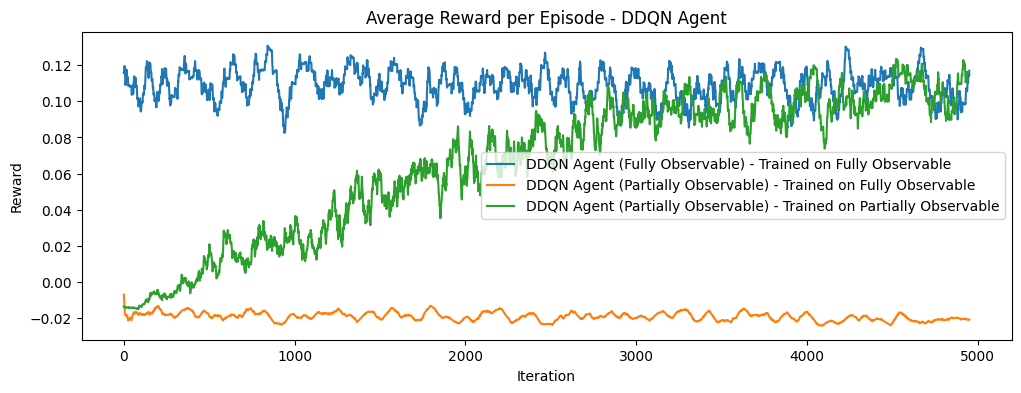

In [19]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(rewards_history_loaded_ddqn, window), label='DDQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_loaded_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(rewards_history_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Reward per Episode - DDQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_ddqn.png", bbox_inches='tight')
plt.show()
plt.close()

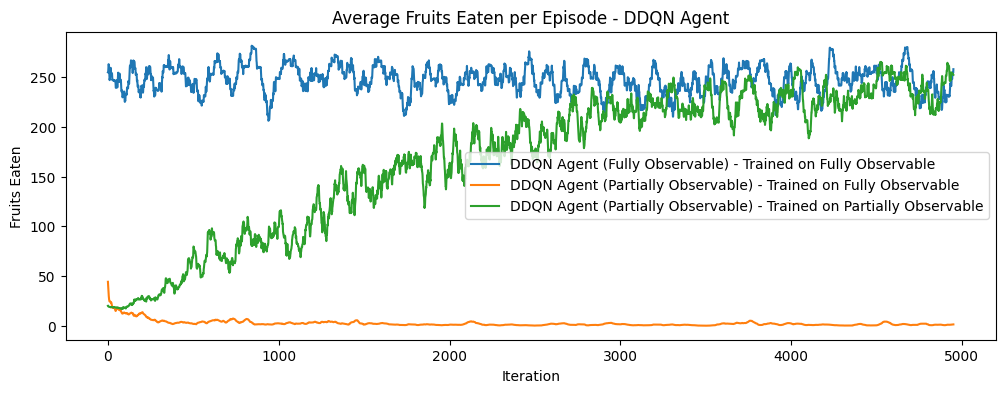

In [38]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_loaded_ddqn, window), label='DDQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_loaded_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(fruits_eaten_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Fruits Eaten per Episode - DDQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten_ddqn.png", bbox_inches='tight')
plt.show()
plt.close()

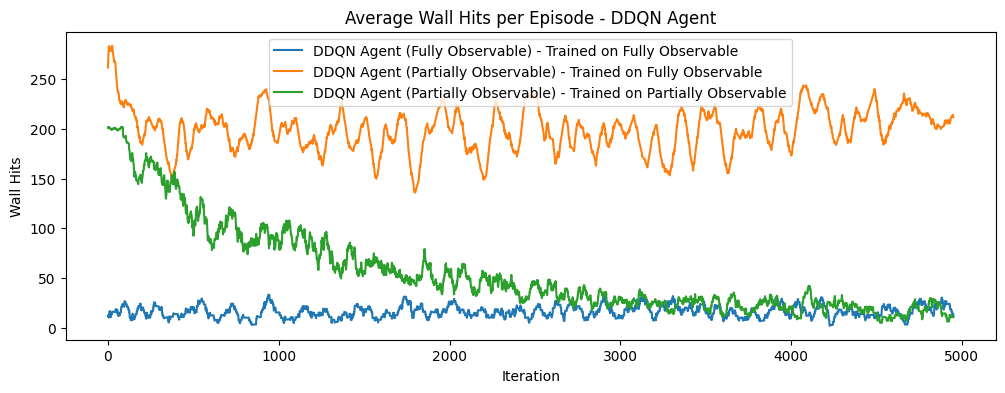

In [39]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits_loaded_ddqn, window), label='DDQN Agent (Fully Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_loaded_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Fully Observable')
plt.plot(moving_average(wall_hits_ddqn_po, window), label='DDQN Agent (Partially Observable) - Trained on Partially Observable')
plt.title('Average Wall Hits per Episode - DDQN Agent')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits_ddqn.png", bbox_inches='tight')
plt.show()
plt.close()

## Heuristic/Baseline Policy

1. **Greedy move toward the fruit**: trying to reduce the Manhattan distance between the head of the snake and the fruit.
2. **Obstacle avoidance**: before moving in the greedy direction, ensure to not hit an obstacle or eat itself
3. **Fallback strategy**: if the snake cannot reach the greedy direction, try the second best one, and so forth so on

In [20]:
UP, RIGHT, DOWN, LEFT = 0, 1, 2, 3
ACTIONS = [UP, RIGHT, DOWN, LEFT]

DIRS = {
    UP: (1, 0),
    RIGHT: (0, 1),
    DOWN: (-1, 0),
    LEFT: (0, -1)
}

def heuristic_policy(env):
    boards = env.boards
    n_boards, board_size, _ = boards.shape
    actions = []

    for i in range(n_boards):
        board = boards[i]
        head = tuple(map(int, np.argwhere(board == env.HEAD)[0]))
        fruit = tuple(map(int, np.argwhere(board == env.FRUIT)[0]))
        candidates = []
        for action in ACTIONS:
            dy, dx = DIRS[action]
            next_pos = (head[0] + dy, head[1] + dx)

            if(0 <= next_pos[0] < board_size) and (0 <= next_pos[1] < board_size):
                target_cell = board[next_pos]
                if target_cell != env.WALL and target_cell != env.BODY:
                    distance = abs(next_pos[0] - fruit[0]) + abs(next_pos[1] - fruit[1])
                    candidates.append((action, distance))
        
        if not candidates:
            action = np.random.choice(ACTIONS)
        else:
            candidates.sort(key=lambda x: x[1])
            action = candidates[0][0]
        actions.append(action)
    
    return tf.convert_to_tensor(actions, dtype=tf.int32)[:, None]

env = get_env()
heuristic_rewards = []
fruits_eaten_heuristic = []
wall_hits_heuristic = []

for iteration in trange(ITERATIONS):
    actions = heuristic_policy(env)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_heuristic.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_heuristic.append(fruits_eaten_count)
    heuristic_rewards.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

    """ if np.sum(dones) > actions.shape[0] / 2:
        env = get_env() # if all the boards are done, reset the environment """

100%|██████████| 5000/5000 [03:31<00:00, 23.68it/s]


### Heuristic - Partially Observable Environment

In [21]:
env = get_env(partially_observable=True)
heuristic_rewards_po = []
fruits_eaten_heuristic_po = []
wall_hits_heuristic_po = []

for iteration in trange(ITERATIONS):
    actions = heuristic_policy(env)
    rewards = env.move(actions)
    wall_hits_count = np.sum(rewards == env.HIT_WALL_REWARD)
    wall_hits_heuristic_po.append(wall_hits_count)
    fruits_eaten_count = np.sum(rewards == env.FRUIT_REWARD)
    fruits_eaten_heuristic_po.append(fruits_eaten_count)
    heuristic_rewards_po.append(np.mean(rewards))
    dones = np.isin(rewards.numpy().flatten(), [env.WIN_REWARD, env.HIT_WALL_REWARD, env.ATE_HIMSELF_REWARD])

    """ if np.sum(dones) > actions.shape[0] / 2:
        env = get_env(partially_observable=True) # if all the boards are done, reset the environment """

100%|██████████| 5000/5000 [03:28<00:00, 23.97it/s]


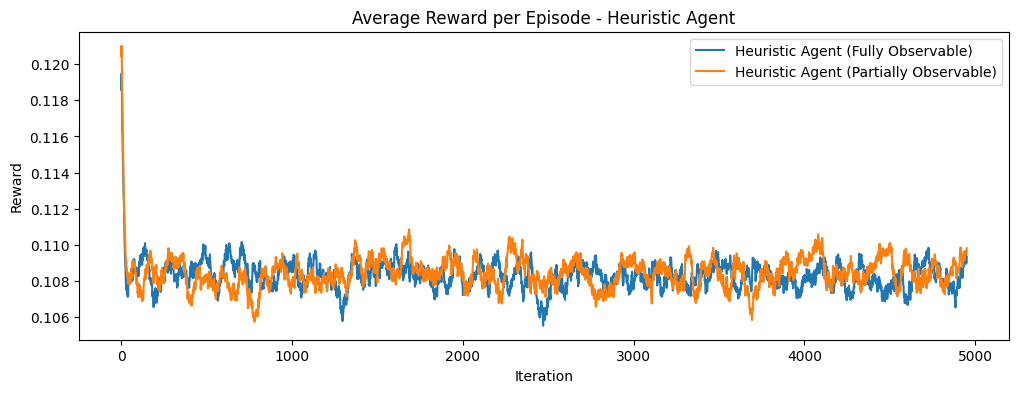

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(heuristic_rewards, window), label='Heuristic Agent (Fully Observable)')
plt.plot(moving_average(heuristic_rewards_po, window), label='Heuristic Agent (Partially Observable)')
plt.title('Average Reward per Episode - Heuristic Agent')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards_heuristic.png", bbox_inches='tight')
plt.show()
plt.close()

 ### Random policy reward
 
Just a baseline (not the one you are supposed to develop)

In [23]:
random_env = get_env(100)
random_rewards = []

for _ in trange(ITERATIONS):
    probs = tf.convert_to_tensor([[.25]*4]*random_env.n_boards)
    #sample actions
    actions =  tf.random.categorical(tf.math.log(probs), 1, dtype=tf.int32)
    # MDP update
    rewards = random_env.move(actions)
    random_rewards.append(np.mean(rewards))

100%|██████████| 5000/5000 [00:20<00:00, 243.31it/s]


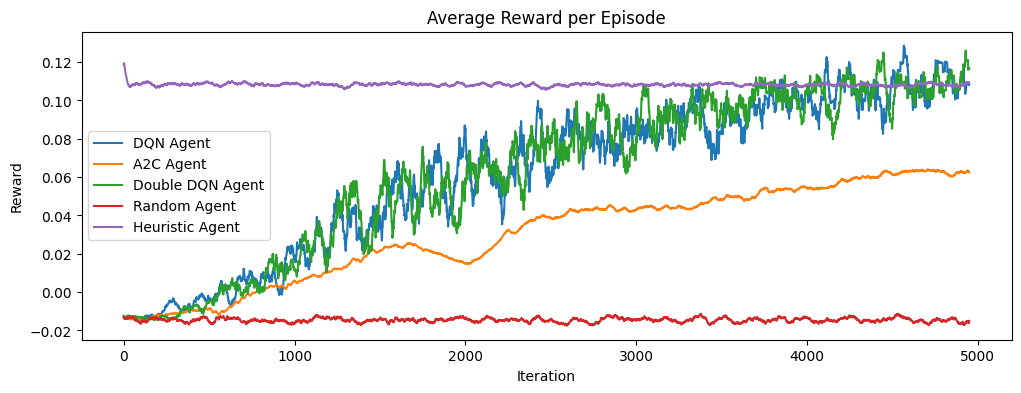

In [24]:
window = 50

def moving_average(data, window):
    return np.convolve(data, np.ones(window)/window, mode='valid')

plt.figure(figsize=(12, 4))

plt.plot(moving_average(rewards_history, window), label='DQN Agent')
plt.plot(moving_average(rewards_history_ac, window), label='A2C Agent')
plt.plot(moving_average(rewards_history_ddqn, window), label='Double DQN Agent')
plt.plot(moving_average(random_rewards, window), label='Random Agent')
plt.plot(moving_average(heuristic_rewards, window), label='Heuristic Agent')
plt.title('Average Reward per Episode')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.savefig("plots/rewards.png", bbox_inches='tight')
plt.show()
plt.close()

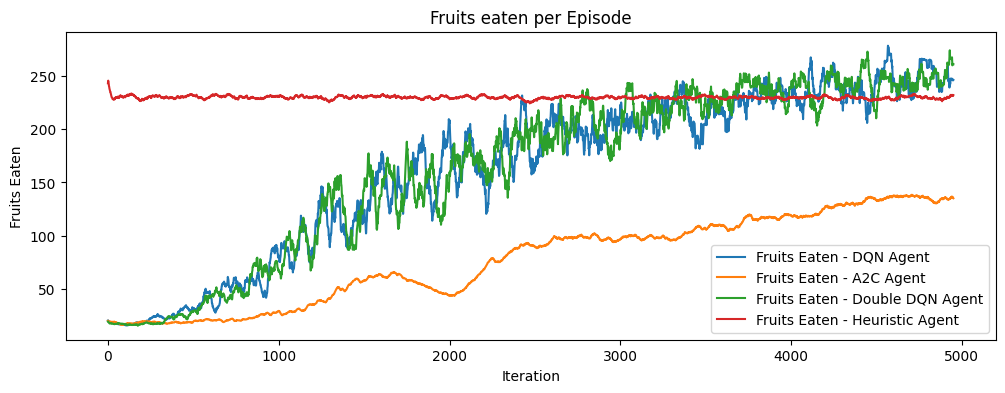

In [25]:
# Plot the fruits eaten
plt.figure(figsize=(12, 4))
plt.plot(moving_average(fruits_eaten_, window), label='Fruits Eaten - DQN Agent')
plt.plot(moving_average(fruits_eaten_ac, window), label='Fruits Eaten - A2C Agent')
plt.plot(moving_average(fruits_eaten_ddqn, window), label='Fruits Eaten - Double DQN Agent')
plt.plot(moving_average(fruits_eaten_heuristic, window), label='Fruits Eaten - Heuristic Agent')
plt.title('Fruits eaten per Episode')
plt.xlabel('Iteration')
plt.ylabel('Fruits Eaten')
plt.legend()
plt.savefig("plots/fruits_eaten.png", bbox_inches='tight')
plt.show()
plt.close()

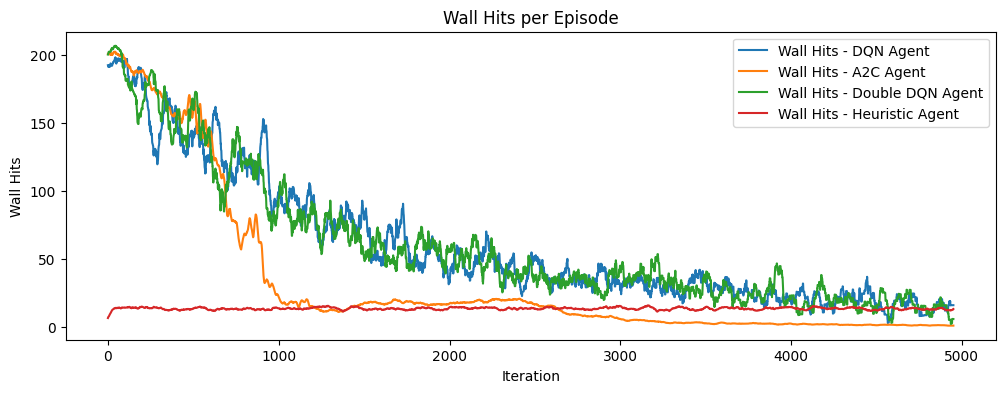

In [41]:
plt.figure(figsize=(12, 4))
plt.plot(moving_average(wall_hits, window), label='Wall Hits - DQN Agent')
plt.plot(moving_average(wall_hits_ac, window), label='Wall Hits - A2C Agent')
plt.plot(moving_average(wall_hits_ddqn, window), label='Wall Hits - Double DQN Agent')
plt.plot(moving_average(wall_hits_heuristic, window), label='Wall Hits - Heuristic Agent')
plt.title('Wall Hits per Episode')
plt.xlabel('Iteration')
plt.ylabel('Wall Hits')
plt.legend()
plt.savefig("plots/wall_hits.png", dpi=300, bbox_inches='tight')
plt.show()
plt.close()